In [42]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import roc_auc_score, roc_curve
import cv2
import zipfile

# Чтение и подготовка данных

Так как я работал в среде на kaggle, то и константы с путями у меня соответсвующие. Для запуска в других средах необходимо будет менять константы приведённые ниже.
### План действий в этой секции:
- считываем необходимые данные по bbox-ам и ключевым точкам;
- обрезаем фотографии согласно bbox-ам и resize-им в нужное соотножение - `TARGET_SIZE`(128x128) и не забываем подвинуть соответсвенно позиции ключевых точек;
- генерируем для каждой фотографии heatmap-ы() и сохраняем их в рабочей директории.

In [2]:
INPUT_DIR_PATH = Path('/kaggle/input/') # Любой другой для нужной среды
DATASET_ARCHIVE_PATH = INPUT_DIR_PATH / 'celeba_subset_10k.zip'
DATASET_PATH = INPUT_DIR_PATH / 'celeba-10k/celeba_subset_10k/'

# Проверяем, существует ли архив
if os.path.exists(DATASET_PATH):
    print(f"Архив уже разархивирован: {DATASET_PATH}")
elif not os.path.exists(DATASET_ARCHIVE_PATH):
    print(f"Архив не найден: {DATASET_ARCHIVE_PATH}")
else:
    with zipfile.ZipFile(DATASET_ARCHIVE_PATH, 'r') as zip_ref:
        zip_ref.extractall(INPUT_DIR_PATH)
    
    print(f"Разархивирование завершено в {INPUT_DIR_PATH}")

Архив уже разархивирован: /kaggle/input/celeba-10k/celeba_subset_10k


In [40]:
# Пути к файлом аннотаций и изображениям (при необходимости можно изменить)
LANDMARKS_PATH = DATASET_PATH / 'annotations/list_landmarks_celeba.txt'
BBOX_PATH = DATASET_PATH / 'annotations/list_bbox_celeba.txt'
IMAGES_PATH = DATASET_PATH / 'images'

WORKING_DIR_PATH = Path('/kaggle/working/')
HEATMAP_PATH = WORKING_DIR_PATH / 'heatmaps'
PROCESSED_IMAGES_PATH = WORKING_DIR_PATH / 'processed_images'
ALIGNED_IMAGES_PATH = WORKING_DIR_PATH / 'aligned_images'
ALIGNED_IMAGES_ZIP = WORKING_DIR_PATH / 'aligned_images.zip'


TARGET_SIZE = (128, 128)  # Размер обрезанных и кропнутых фотографий (height, width)
SIGMA = 2

BATCH_SIZE = 4
NUM_WORKERS = 2

In [4]:
bbox_df = pd.read_csv(BBOX_PATH, sep=r'\s+', skiprows=1)

bbox_df = bbox_df.set_index('image_id')

bbox_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10013 entries, 004962.jpg to 151947.jpg
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x_1     10013 non-null  int64
 1   y_1     10013 non-null  int64
 2   width   10013 non-null  int64
 3   height  10013 non-null  int64
dtypes: int64(4)
memory usage: 391.1+ KB


In [5]:
landmarks_df = pd.read_csv(LANDMARKS_PATH, sep=r'\s+', skiprows=2,
                           names=['image_id','lefteye_x','lefteye_y','righteye_x','righteye_y','nose_x','nose_y',
                                  'leftmouth_x', 'leftmouth_y', 'rightmouth_x','rightmouth_y'])

landmarks_df = landmarks_df.set_index('image_id')

landmarks_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10013 entries, 004962.jpg to 151947.jpg
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   lefteye_x     10013 non-null  int64
 1   lefteye_y     10013 non-null  int64
 2   righteye_x    10013 non-null  int64
 3   righteye_y    10013 non-null  int64
 4   nose_x        10013 non-null  int64
 5   nose_y        10013 non-null  int64
 6   leftmouth_x   10013 non-null  int64
 7   leftmouth_y   10013 non-null  int64
 8   rightmouth_x  10013 non-null  int64
 9   rightmouth_y  10013 non-null  int64
dtypes: int64(10)
memory usage: 860.5+ KB


In [6]:
# Вспомогательные функции для обрезки фотографий

def crop_and_resize_image(image, bbox, target_size):
    """
    Обрезает изображение по bbox и ресайзит до target_size.
    
    :param image: PIL Image
    :param bbox: (x, y, width, height)
    :param target_size: (height, width)
    :return: resized PIL Image, scale_factors (scale_x, scale_y)
    """
    x, y, w, h = bbox
    
    # Обрезаем по bbox
    cropped = image.crop((x, y, x + w, y + h))
    
    # Вычисляем масштабные коэффициенты
    orig_w, orig_h = cropped.size  # PIL: (width, height)
    target_h, target_w = target_size
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h
    
    # Ресайзим
    resized = cropped.resize((target_w, target_h), Image.BILINEAR)
    
    return resized, (scale_x, scale_y)


def transform_landmarks(landmarks, bbox, scale_factors):
    """
    Пересчитывает координаты landmarks после crop и resize.
    
    :param landmarks: список [(x1, y1), (x2, y2), ...]
    :param bbox: (x, y, width, height) - параметры crop
    :param scale_factors: (scale_x, scale_y) - коэффициенты resize
    :return: новые координаты landmarks
    """
    bbox_x, bbox_y, _, _ = bbox
    scale_x, scale_y = scale_factors
    
    transformed = []
    for (x, y) in landmarks:
        # Сдвигаем относительно bbox (crop)
        new_x = x - bbox_x
        new_y = y - bbox_y
        
        # Масштабируем (resize)
        new_x = new_x * scale_x
        new_y = new_y * scale_y
        
        transformed.append((new_x, new_y))
    
    return transformed


In [7]:
# Вспомагательные функции для генерации heatmap

def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark: (x, y) — координаты точки
    :param sigma: стандартное отклонение гауссиана
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN)]
    :param sigma: стандартное отклонение гауссиана
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for (x, y) in landmarks:
        hm = create_heatmap(image_shape, (x, y), sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

In [8]:
# Создадим heatmap-ы для каждой картинки

os.makedirs(HEATMAP_PATH, exist_ok=True)
os.makedirs(PROCESSED_IMAGES_PATH, exist_ok=True)

# Статистика
successful = 0
failed = 0

data = landmarks_df.join(bbox_df, how='inner')

# Обрабатываем каждое изображение
for image_id, row in tqdm(data.iterrows(), total=len(data), desc="Processing"):
    try:
        # 1. Загружаем изображение
        img_path = IMAGES_PATH / image_id
        image = Image.open(img_path)
        
        # 2. Получаем bbox
        bbox = (int(row['x_1']), int(row['y_1']), 
                int(row['width']), int(row['height']))
        
        # 3. Crop и resize
        resized_image, scale_factors = crop_and_resize_image(image, bbox, TARGET_SIZE)
        
        # 4. Получаем исходные landmarks
        landmarks = [
            (row['lefteye_x'], row['lefteye_y']),
            (row['righteye_x'], row['righteye_y']),
            (row['nose_x'], row['nose_y']),
            (row['leftmouth_x'], row['leftmouth_y']),
            (row['rightmouth_x'], row['rightmouth_y'])
        ]
        
        # 5. Трансформируем landmarks
        transformed_landmarks = transform_landmarks(landmarks, bbox, scale_factors)
        
        # 6. Генерируем heatmaps
        heatmaps = landmarks_to_heatmaps(TARGET_SIZE, transformed_landmarks, sigma=SIGMA)
        
        # 7. Сохраняем изображение
        image_output_path = os.path.join(PROCESSED_IMAGES_PATH, image_id)
        resized_image.save(image_output_path, quality=95)
        
        # 8. Сохраняем heatmaps (uint8 + compressed для экономии места)
        heatmaps_uint8 = (heatmaps * 255).astype(np.uint8)
        heatmap_output_path = os.path.join(HEATMAP_PATH, image_id.replace('.jpg', '.npz'))
        np.savez_compressed(heatmap_output_path, heatmaps=heatmaps_uint8)
        
        successful += 1
        
    except Exception as e:
        failed += 1
        if failed <= 5:  # Показываем только первые 5 ошибок
            print(f"\n⚠️  Error processing {image_id}: {e}")


Processing: 100%|██████████| 10013/10013 [01:30<00:00, 111.08it/s]



📊 Example 1/3: 089462.jpg


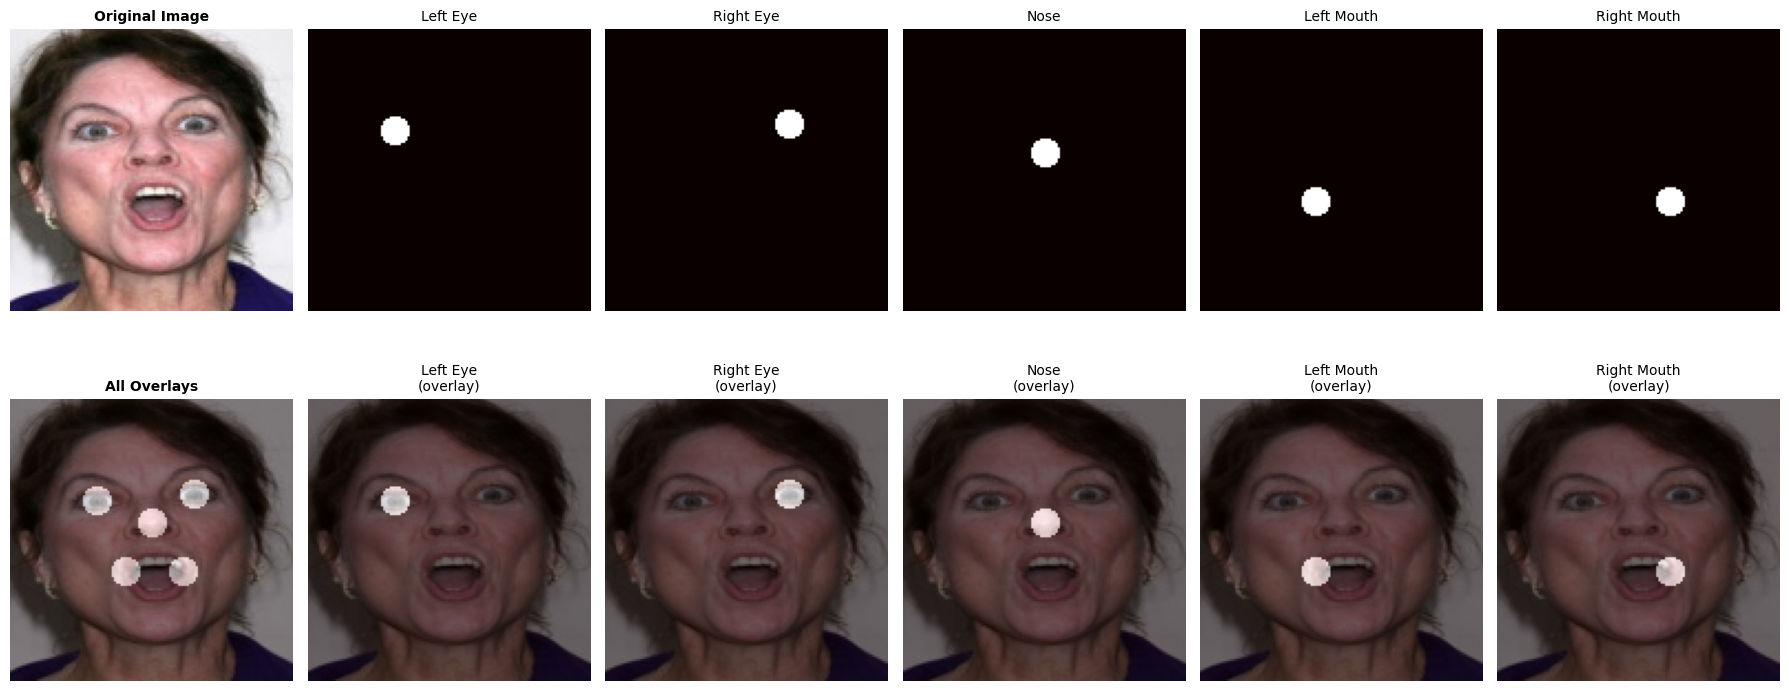


📊 Example 2/3: 137404.jpg


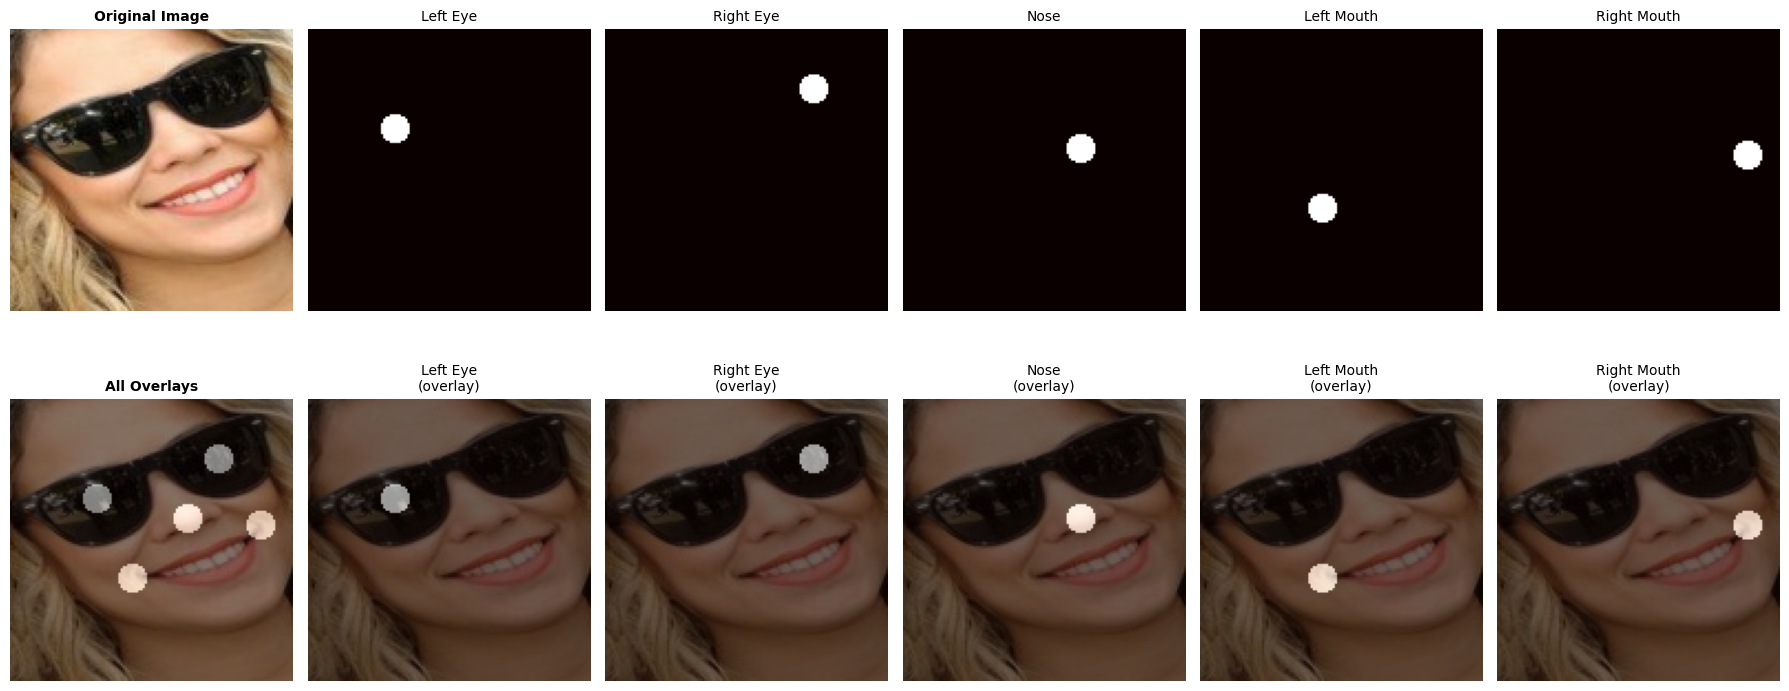


📊 Example 3/3: 179960.jpg


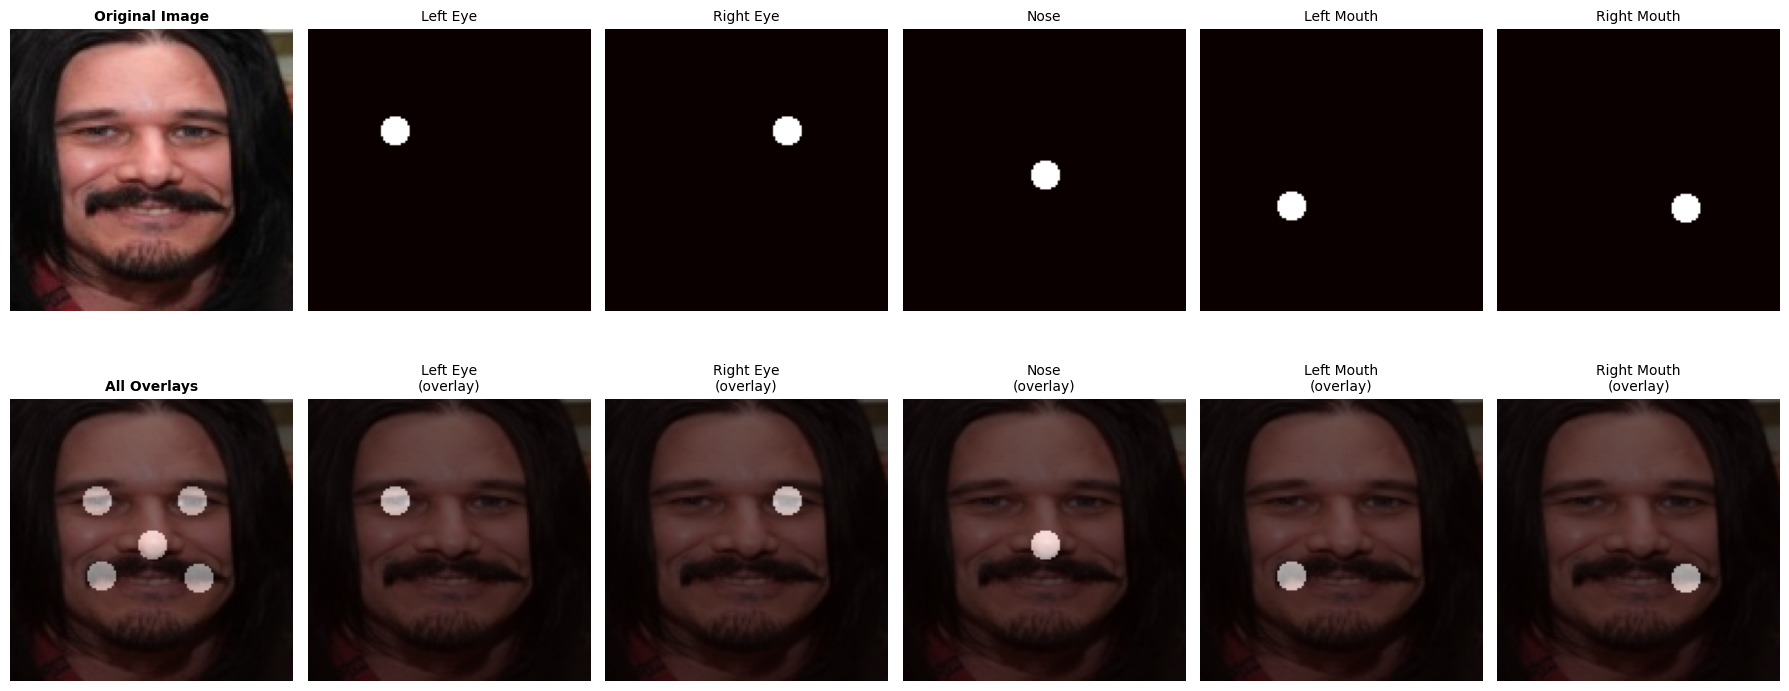

In [9]:
# Визуализация обрезанных фото с heatmap-ами

def visualize_heatmaps(image, heatmaps, landmark_names=None, figsize=(15, 10)):
    """
    Визуализирует изображение с наложенными heatmaps.
    
    :param image: PIL Image или numpy array (H, W, 3) или (H, W)
    :param heatmaps: numpy array формата (N, H, W) где N - количество landmarks
    :param landmark_names: список названий landmarks (опционально)
    :param figsize: размер фигуры matplotlib
    """
    # Конвертируем image в numpy array если это PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Нормализуем изображение к [0, 1] если нужно
    if image.dtype == np.uint8:
        image = image.astype(np.float32) / 255.0
    
    # Проверяем размерности heatmaps
    if len(heatmaps.shape) != 3:
        raise ValueError(f"Heatmaps должны быть формата (N, H, W), получено: {heatmaps.shape}")
    
    num_landmarks = heatmaps.shape[0]
    
    # Дефолтные названия если не заданы
    if landmark_names is None:
        landmark_names = [f"Landmark {i+1}" for i in range(num_landmarks)]
    
    # Создаём сетку: 2 ряда (верхний - heatmaps, нижний - наложенные)
    fig, axes = plt.subplots(2, num_landmarks + 1, figsize=figsize)
    
    # Верхний ряд: оригинальное изображение + отдельные heatmaps
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image", fontsize=10, fontweight='bold')
    axes[0, 0].axis('off')
    
    for i in range(num_landmarks):
        axes[0, i+1].imshow(heatmaps[i], cmap='hot', vmin=0, vmax=1)
        axes[0, i+1].set_title(landmark_names[i], fontsize=10)
        axes[0, i+1].axis('off')
    
    # Нижний ряд: изображение с наложенными heatmaps
    axes[1, 0].imshow(image)
    # Накладываем все heatmaps вместе
    combined_heatmap = np.max(heatmaps, axis=0)
    axes[1, 0].imshow(combined_heatmap, cmap='hot', alpha=0.5, vmin=0, vmax=1)
    axes[1, 0].set_title("All Overlays", fontsize=10, fontweight='bold')
    axes[1, 0].axis('off')
    
    for i in range(num_landmarks):
        axes[1, i+1].imshow(image)
        axes[1, i+1].imshow(heatmaps[i], cmap='hot', alpha=0.6, vmin=0, vmax=1)
        axes[1, i+1].set_title(f"{landmark_names[i]}\n(overlay)", fontsize=10)
        axes[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Названия landmarks для CelebA
LANDMARK_NAMES = [
    "Left Eye",
    "Right Eye", 
    "Nose",
    "Left Mouth",
    "Right Mouth"
]

# Получаем список всех preprocessed изображений
image_files = [f for f in os.listdir(PROCESSED_IMAGES_PATH) if f.endswith('.jpg')]

# Выбираем N случайных файлов
num_samples = 3
random_files = random.sample(image_files, min(num_samples, len(image_files)))

for i, image_file in enumerate(random_files, 1):
    print(f"\n📊 Example {i}/{len(random_files)}: {image_file}")
    
    # Загружаем изображение
    image_path = os.path.join(PROCESSED_IMAGES_PATH, image_file)
    image = Image.open(image_path)
    
    # Загружаем соответствующие heatmaps
    heatmap_file = image_file.replace('.jpg', '.npz')
    heatmap_path = os.path.join(HEATMAP_PATH, heatmap_file)
    
    if not os.path.exists(heatmap_path):
        print(f"Heatmap file not found: {heatmap_file}")
        continue
    
    heatmaps_data = np.load(heatmap_path)
    heatmaps = heatmaps_data['heatmaps']
    
    # Визуализируем
    visualize_heatmaps(image, heatmaps, landmark_names=LANDMARK_NAMES, figsize=(18, 8))

# Сборка датасета
Собираем фотографии и heatmap-ы вместе под одним объектом Dataset.
После разделим датасет на train/val/test выборки

In [ ]:
class CelebALandmarksDataset(Dataset):
    def __init__(self, image_files, images_dir=PROCESSED_IMAGES_PATH, heatmaps_dir=HEATMAP_PATH, transform=None):
        """
        :param image_files: список имён файлов изображений
        :param images_dir: путь к директории с изображениями
        :param heatmaps_dir: путь к директории с heatmaps
        :param transform: опциональные трансформации для изображений
        """
        self.image_files = image_files
        self.images_dir = images_dir
        self.heatmaps_dir = heatmaps_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]

        image_path = os.path.join(self.images_dir, image_file)
        image = Image.open(image_path).convert('RGB')

        heatmap_file = image_file.replace('.jpg', '.npz')
        heatmap_path = os.path.join(self.heatmaps_dir, heatmap_file)
        heatmaps_data = np.load(heatmap_path)
        heatmaps = heatmaps_data['heatmaps']

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0

        heatmaps = torch.from_numpy(heatmaps).float() / 255.0
        
        return {
            'image': image,
            'heatmaps': heatmaps,
            'filename': image_file
        }

In [11]:
# Функция для разделения на train/val/test

def create_train_val_test_split(image_files, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):    
    train_val_files, test_files = train_test_split(
        image_files,
        test_size=test_ratio,
        random_state=random_state
    )

    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    train_files, val_files = train_test_split(
        train_val_files,
        test_size=val_ratio_adjusted,
        random_state=random_state
    )
    
    return train_files, val_files, test_files

In [12]:
all_image_files = sorted([f for f in os.listdir(PROCESSED_IMAGES_PATH) if f.endswith('.jpg')])
print(f"\nTotal images: {len(all_image_files)}")

train_files, val_files, test_files = create_train_val_test_split(
    all_image_files,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=42
)

print(f"\nDataset split:")
print(f"  Train: {len(train_files)} ({len(train_files)/len(all_image_files)*100:.1f}%)")
print(f"  Val:   {len(val_files)} ({len(val_files)/len(all_image_files)*100:.1f}%)")
print(f"  Test:  {len(test_files)} ({len(test_files)/len(all_image_files)*100:.1f}%)")

train_dataset = CelebALandmarksDataset(
    image_files=train_files,
    transform=None
)

val_dataset = CelebALandmarksDataset(
    image_files=val_files,
    transform=None
)

test_dataset = CelebALandmarksDataset(
    image_files=test_files,
    transform=None
)


Total images: 10013

Dataset split:
  Train: 7009 (70.0%)
  Val:   1502 (15.0%)
  Test:  1502 (15.0%)


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

batch = next(iter(train_loader))

print(f"\nBatch from train loader:")
print(f"  Images shape:    {batch['image'].shape}")
print(f"  Heatmaps shape:  {batch['heatmaps'].shape}")
print(f"  Batch size:      {len(batch['filename'])}")


Batch from train loader:
  Images shape:    torch.Size([4, 3, 128, 128])
  Heatmaps shape:  torch.Size([4, 5, 128, 128])
  Batch size:      4


# Stacked Hourglass Network
Соберём модель для обучения используя `ResidualBlock` из ноутбука с заданием

## Обучение

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [ ]:
class HourglassModule(nn.Module):    
    def __init__(self, depth, num_features):
        """
        Args:
            depth: глубина рекурсии (количество уровней понижения разрешения)
            num_features: количество каналов на этом уровне
        """
        super().__init__()
        self.depth = depth
        
        # Верхняя ветка (skip connection)
        self.upper_branch = ResidualBlock(num_features, num_features)
        
        # Нижняя ветка - downsampling
        self.pool = nn.MaxPool2d(2, stride=2)
        self.lower_pre = ResidualBlock(num_features, num_features)
        
        # Уменьшаем количество каналов для следующего уровня
        next_features = num_features // 2
        self.reduce_channels = nn.Conv2d(num_features, next_features, kernel_size=1)
        
        if depth > 1:
            # Рекурсивно создаем следующий уровень с уменьшенным количеством каналов
            self.lower_main = HourglassModule(depth - 1, next_features)
        else:
            # Самый глубокий уровень
            self.lower_main = ResidualBlock(next_features, next_features)
        
        # Увеличиваем количество каналов обратно после рекурсии
        self.expand_channels = nn.Conv2d(next_features, num_features, kernel_size=1)
        
        self.lower_post = ResidualBlock(num_features, num_features)
        
        # Нижняя ветка - upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    
    def forward(self, x):
        up = self.upper_branch(x)
        
        low = self.pool(x)
        low = self.lower_pre(low)

        low = self.reduce_channels(low)
        low = self.lower_main(low)

        low = self.expand_channels(low)
        
        low = self.lower_post(low)
        low = self.upsample(low)
        
        return up + low

In [ ]:
class StackedHourglassNetwork(nn.Module):    
    def __init__(self, num_stacks, num_blocks, num_features, num_keypoints, input_channels=3):
        """
        Args:
            num_stacks: количество hourglass модулей в стеке
            num_blocks: глубина каждого hourglass модуля
            num_features: количество каналов в hourglass модулях
            num_keypoints: количество ключевых точек (размер heatmap)
            input_channels: количество входных каналов (обычно 3 для RGB)
        """
        super().__init__()
        self.num_stacks = num_stacks
        self.num_keypoints = num_keypoints
        
        # Сохраняем исходное разрешение изображения
        self.preprocessing = nn.Sequential(
            # Первая свертка БЕЗ stride (сохраняем разрешение)
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Residual blocks для извлечения признаков
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, num_features)
        )
        
        # Создаем hourglass модули
        self.hourglasses = nn.ModuleList([
            HourglassModule(depth=num_blocks, num_features=num_features)
            for _ in range(num_stacks)
        ])
        
        # Residual блоки после каждого hourglass
        self.post_hg_res = nn.ModuleList([
            ResidualBlock(num_features, num_features)
            for _ in range(num_stacks)
        ])
        
        # Головы для генерации heatmaps
        self.heatmap_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features),
                nn.ReLU(inplace=True),
                nn.Conv2d(num_features, num_keypoints, kernel_size=1)
            )
            for _ in range(num_stacks)
        ])
        
        # Проекция heatmap обратно в пространство признаков
        self.heatmap_to_features = nn.ModuleList([
            nn.Conv2d(num_keypoints, num_features, kernel_size=1)
            for _ in range(num_stacks - 1)
        ])
        
        # Проекция выхода hourglass для суммирования
        self.features_projection = nn.ModuleList([
            nn.Conv2d(num_features, num_features, kernel_size=1)
            for _ in range(num_stacks - 1)
        ])
    
    def forward(self, x):
        """
        Args:
            x: входной тензор [batch_size, input_channels, height, width]
        
        Returns:
            heatmaps: список heatmaps от каждого стека для intermediate supervision
        """
        x = self.preprocessing(x)
        
        heatmaps = []
        inter_features = x
        
        for i in range(self.num_stacks):
            # Пропускаем через hourglass модуль
            hg_out = self.hourglasses[i](inter_features)
            
            # Применяем residual блок после hourglass
            features = self.post_hg_res[i](hg_out)
            
            # Генерируем heatmap
            heatmap = self.heatmap_heads[i](features)
            heatmaps.append(heatmap)
            
            # Если это не последний стек, подготавливаем вход для следующего
            if i < self.num_stacks - 1:
                # Проецируем heatmap обратно в пространство признаков
                heatmap_features = self.heatmap_to_features[i](heatmap)
                
                # Проецируем выход hourglass
                projected_features = self.features_projection[i](features)
                
                # Суммируем
                inter_features = inter_features + projected_features + heatmap_features
        
        return heatmaps

In [ ]:
# Класс для обучения Stacked Hourglass Network
class FacialLandmarksTrainer:    
    def __init__(self, model, criterion, train_loader, val_loader, device='cuda', 
                 learning_rate=1e-3, num_stacks=4):
        """
        Args:
            model: Stacked Hourglass Network
            train_loader: DataLoader для обучающей выборки
            val_loader: DataLoader для валидационной выборки
            device: устройство для вычислений
            learning_rate: learning rate для оптимизатора
            num_stacks: количество стеков в модели (для intermediate supervision)
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_stacks = num_stacks

        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )

        self.criterion = criterion

        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
    
    def train_epoch(self, epoch):
        self.model.train()
        epoch_loss = 0.0
        
        progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch}')
        
        for _, batch in enumerate(progress_bar):
            images = batch['image'].to(self.device)  # [B, C, H, W]
            gt_heatmaps = batch['heatmaps'].to(self.device)  # [B, num_keypoints, H, W]

            self.optimizer.zero_grad()
            pred_heatmaps = self.model(images)

            # Вычисляем loss для каждого стека (intermediate supervision) и усредняем
            loss = 0
            for stack_idx in range(self.num_stacks):
                loss += self.criterion(pred_heatmaps[stack_idx], gt_heatmaps)

            loss = loss / self.num_stacks

            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_loss = epoch_loss / len(self.train_loader)

        return avg_loss
    
    def validate(self):
        self.model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                images = batch['image'].to(self.device)
                gt_heatmaps = batch['heatmaps'].to(self.device)

                pred_heatmaps = self.model(images)
                
                # Вычисляем loss (используем только последний стек для валидации)
                loss = self.criterion(pred_heatmaps[-1], gt_heatmaps)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(self.val_loader)

        return avg_val_loss
    
    def train(self, num_epochs, save_path='best_model.pth'):
        """
        Args:
            num_epochs: количество эпох
            save_path: путь для сохранения лучшей модели
        """
        print(f"Начинаем обучение на {self.device}")
        print(f"Количество эпох: {num_epochs}")
        print(f"Размер обучающей выборки: {len(self.train_loader.dataset)}")
        print(f"Размер валидационной выборки: {len(self.val_loader.dataset)}")
        
        for epoch in range(1, num_epochs + 1):
            train_loss = self.train_epoch(epoch)

            val_loss = self.validate()

            self.scheduler.step(val_loss)

            print(f"Epoch {epoch}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.6f}")
            print(f"  Val Loss:   {val_loss:.6f}")
            print(f"  LR: {self.optimizer.param_groups[0]['lr']:.6f}")

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses
                }, save_path)
                print(f"  ✓ Сохранена лучшая модель (Val Loss: {val_loss:.6f})")
            
            print("-" * 60)
        
        print("Обучение завершено!")
        print(f"Лучший Val Loss: {self.best_val_loss:.6f}")

In [ ]:
# Из-за частого переполнения памяти часто приходилось прибегать к этой ячейке
if 'model' in globals():
    del model
if 'trainer' in globals():
    del trainer

torch.cuda.empty_cache()
gc.collect()

26964

In [ ]:
model = StackedHourglassNetwork(
    num_stacks=3,
    num_blocks=4,
    num_features=128,
    num_keypoints=5,
    input_channels=3,
)

trainer = FacialLandmarksTrainer(
    model=model,
    criterion=nn.MSELoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    learning_rate=1e-3,
    num_stacks=3
)

In [38]:
# Запускаем обучение
#trainer.train(num_epochs=10, save_path='best_hourglass_model.pth')

Начинаем обучение на cuda
Количество эпох: 10
Размер обучающей выборки: 7009
Размер валидационной выборки: 1502


Validation: 100%|██████████| 376/376 [00:25<00:00, 15.01it/s]


Epoch 1/10
  Train Loss: 0.001311
  Val Loss:   0.000327
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000327)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.08it/s]


Epoch 2/10
  Train Loss: 0.000466
  Val Loss:   0.000183
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000183)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:25<00:00, 15.00it/s]


Epoch 3/10
  Train Loss: 0.000244
  Val Loss:   0.000145
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000145)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:25<00:00, 15.02it/s]


Epoch 4/10
  Train Loss: 0.000168
  Val Loss:   0.000147
  LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.09it/s]


Epoch 5/10
  Train Loss: 0.000150
  Val Loss:   0.000144
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000144)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.12it/s]


Epoch 6/10
  Train Loss: 0.000140
  Val Loss:   0.000142
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000142)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.09it/s]


Epoch 7/10
  Train Loss: 0.000133
  Val Loss:   0.000126
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000126)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.15it/s]


Epoch 8/10
  Train Loss: 0.000127
  Val Loss:   0.000133
  LR: 0.001000
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.08it/s]


Epoch 9/10
  Train Loss: 0.000124
  Val Loss:   0.000123
  LR: 0.001000
  ✓ Сохранена лучшая модель (Val Loss: 0.000123)
------------------------------------------------------------


Validation: 100%|██████████| 376/376 [00:24<00:00, 15.19it/s]

Epoch 10/10
  Train Loss: 0.000118
  Val Loss:   0.000128
  LR: 0.001000
------------------------------------------------------------
Обучение завершено!
Лучший Val Loss: 0.000123


In [ ]:
# Здесь руками сохранил веса модели после обучения(не только лучшую)
torch.save({
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'train_losses': trainer.train_losses,
    'val_losses': trainer.val_losses
}, 'hourglass_model_10_epoch.pth')

In [ ]:
# Тут и далее я просто загружался с чекпоинта, скипая долгий процесс обучения
checkpoint = torch.load('/kaggle/input/hourglass-10/pytorch/default/1/hourglass_model_10_epoch.pth')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

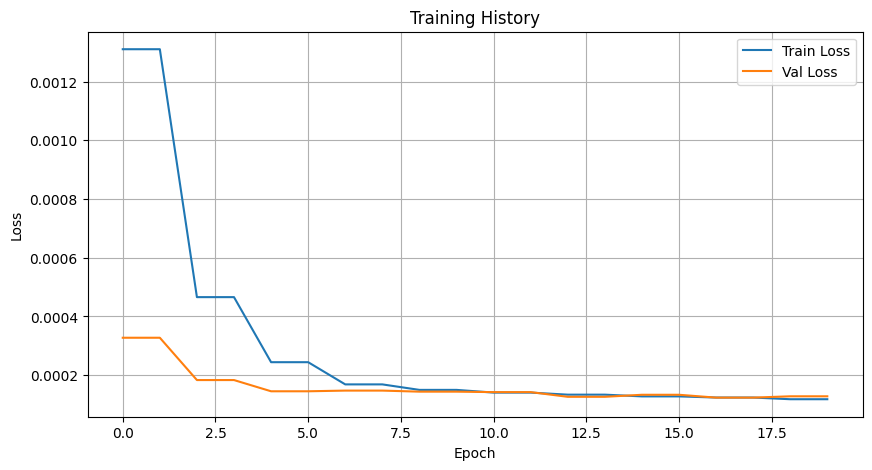

In [33]:
def plot_training_history(train_losses, val_losses):        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training_history(checkpoint['train_losses'], checkpoint['val_losses'])

## Inference

In [ ]:
class ModelEvaluator:    
    def __init__(self, model, test_loader, device='cuda'):
        """
        Args:
            model: обученная модель
            test_loader: DataLoader с тестовыми данными
            device: устройство для вычислений
        """
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.model.eval()
    
    def compute_metrics(self):
        """
        Вычисляет метрики на тестовом датасете
        
        Returns:
            dict с метриками
        """
        all_predictions = []
        all_targets = []
        all_images = []
        
        print("Вычисление метрик на тестовом датасете...")
        
        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc='Testing'):
                images = batch['image'].to(self.device)
                gt_heatmaps = batch['heatmaps'].to(self.device)

                pred_heatmaps = self.model(images)
                pred = pred_heatmaps[-1]  # Берем последний стек

                pred_np = pred.cpu().numpy()
                gt_np = gt_heatmaps.cpu().numpy()
                images_np = images.cpu().numpy()
                
                all_predictions.append(pred_np)
                all_targets.append(gt_np)
                all_images.append(images_np)

        predictions = np.concatenate(all_predictions, axis=0)  # [N, num_keypoints, H, W]
        targets = np.concatenate(all_targets, axis=0)
        images = np.concatenate(all_images, axis=0)

        metrics = self._calculate_metrics(predictions, targets)
        
        return metrics, predictions, targets, images
    
    def _calculate_metrics(self, predictions, targets):
        """
        Вычисляет различные метрики
        
        Args:
            predictions: [N, num_keypoints, H, W]
            targets: [N, num_keypoints, H, W]
        """
        metrics = {}
        
        # ROC AUC Score
        pred_flat = predictions.flatten()
        target_flat = targets.flatten()
        target_binary = (target_flat > 0.5).astype(int)
        
        try:
            roc_auc = roc_auc_score(target_binary, pred_flat)
            metrics['roc_auc'] = roc_auc
        except:
            metrics['roc_auc'] = None
            print("Предупреждение: не удалось вычислить ROC AUC")
        
        # MSE
        mse = np.mean((predictions - targets) ** 2)
        metrics['mse'] = mse
        
        # MAE
        mae = np.mean(np.abs(predictions - targets))
        metrics['mae'] = mae
        
        # PSNR
        max_val = 1.0
        psnr = 20 * np.log10(max_val / np.sqrt(mse)) if mse > 0 else float('inf')
        metrics['psnr'] = psnr
        
        # Top-1 Accuracy (с разными порогами)
        top1_acc_3px = self._calculate_top1_accuracy(predictions, targets, threshold=3)
        top1_acc_5px = self._calculate_top1_accuracy(predictions, targets, threshold=5)
        top1_acc_10px = self._calculate_top1_accuracy(predictions, targets, threshold=10)
        
        metrics['top1_accuracy_3px'] = top1_acc_3px
        metrics['top1_accuracy_5px'] = top1_acc_5px
        metrics['top1_accuracy_10px'] = top1_acc_10px
        
        # Mean Error Distance
        mean_error, per_keypoint_error = self._calculate_mean_error(predictions, targets)
        metrics['mean_error_distance'] = mean_error
        metrics['per_keypoint_error'] = per_keypoint_error
        
        # Точность локализации
        keypoint_accuracy = self._calculate_keypoint_accuracy(predictions, targets, threshold=5)
        metrics['keypoint_accuracy'] = keypoint_accuracy
        
        return metrics
    
    def _calculate_top1_accuracy(self, predictions, targets, threshold=5):
        """
        Вычисляет top-1 accuracy для ключевых точек
        
        Args:
            predictions: [N, num_keypoints, H, W]
            targets: [N, num_keypoints, H, W]
            threshold: порог расстояния в пикселях
        
        Returns:
            top-1 accuracy (0-1)
        """
        N, num_keypoints, H, W = predictions.shape
        correct = 0
        total = 0
        
        for i in range(N):
            for k in range(num_keypoints):
                # Находим координаты максимума в предсказании
                pred_heatmap = predictions[i, k]
                pred_max_idx = np.argmax(pred_heatmap)
                pred_y, pred_x = np.unravel_index(pred_max_idx, pred_heatmap.shape)
                
                # Находим координаты максимума в ground truth
                target_heatmap = targets[i, k]
                target_max_idx = np.argmax(target_heatmap)
                target_y, target_x = np.unravel_index(target_max_idx, target_heatmap.shape)

                distance = np.sqrt((pred_x - target_x)**2 + (pred_y - target_y)**2)

                if distance <= threshold:
                    correct += 1
                
                total += 1
        
        accuracy = correct / total if total > 0 else 0
        return accuracy
    
    def _calculate_mean_error(self, predictions, targets):
        """
        Вычисляет среднюю ошибку локализации в пикселях
        
        Args:
            predictions: [N, num_keypoints, H, W]
            targets: [N, num_keypoints, H, W]
        
        Returns:
            mean_error: средняя ошибка по всем точкам
            per_keypoint_error: ошибка для каждой ключевой точки
        """
        N, num_keypoints, H, W = predictions.shape
        errors = []
        per_keypoint_errors = [[] for _ in range(num_keypoints)]
        
        for i in range(N):
            for k in range(num_keypoints):
                # Находим координаты максимумов
                pred_heatmap = predictions[i, k]
                pred_max_idx = np.argmax(pred_heatmap)
                pred_y, pred_x = np.unravel_index(pred_max_idx, pred_heatmap.shape)
                
                target_heatmap = targets[i, k]
                target_max_idx = np.argmax(target_heatmap)
                target_y, target_x = np.unravel_index(target_max_idx, target_heatmap.shape)

                distance = np.sqrt((pred_x - target_x)**2 + (pred_y - target_y)**2)
                
                errors.append(distance)
                per_keypoint_errors[k].append(distance)
        
        mean_error = np.mean(errors)
        per_keypoint_mean = [np.mean(err) for err in per_keypoint_errors]
        
        return mean_error, per_keypoint_mean
    
    def _calculate_keypoint_accuracy(self, predictions, targets, threshold=5):
        """
        Вычисляет точность локализации ключевых точек
        """
        return self._calculate_top1_accuracy(predictions, targets, threshold)
    
    def plot_roc_curve(self, predictions, targets):
        """Строит ROC кривую"""
        pred_flat = predictions.flatten()
        target_flat = targets.flatten()
        target_binary = (target_flat > 0.5).astype(int)
        
        fpr, tpr, _ = roc_curve(target_binary, pred_flat)
        roc_auc = roc_auc_score(target_binary, pred_flat)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_accuracy_by_threshold(self, predictions, targets, max_threshold=20):
        """
        Строит график зависимости accuracy от порога расстояния
        
        Args:
            predictions: [N, num_keypoints, H, W]
            targets: [N, num_keypoints, H, W]
            max_threshold: максимальный порог в пикселях
        """
        thresholds = range(1, max_threshold + 1)
        accuracies = []
        
        for thresh in tqdm(thresholds, desc='Computing accuracy curve'):
            acc = self._calculate_top1_accuracy(predictions, targets, threshold=thresh)
            accuracies.append(acc)
        
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, accuracies, 'b-', linewidth=2, marker='o')
        plt.xlabel('Distance Threshold (pixels)', fontsize=12)
        plt.ylabel('Top-1 Accuracy', fontsize=12)
        plt.title('Accuracy vs Distance Threshold', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xlim([0, max_threshold])
        plt.ylim([0, 1.05])
        
        # Добавляем горизонтальные линии для важных порогов
        for thresh in [3, 5, 10]:
            if thresh <= max_threshold:
                idx = thresh - 1
                plt.axhline(y=accuracies[idx], color='r', linestyle='--', alpha=0.5)
                plt.text(max_threshold * 0.7, accuracies[idx] + 0.02, 
                        f'{thresh}px: {accuracies[idx]:.2%}', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def plot_per_keypoint_error(self, metrics, keypoint_names=None):
        """
        Визуализирует ошибку для каждой ключевой точки
        
        Args:
            metrics: словарь с метриками
            keypoint_names: названия ключевых точек
        """
        if keypoint_names is None:
            keypoint_names = ['Left Eye', 'Right Eye', 'Nose', 
                            'Left Mouth', 'Right Mouth']
        
        per_keypoint_error = metrics['per_keypoint_error']
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(len(per_keypoint_error)), per_keypoint_error, 
                       color='steelblue', alpha=0.7)
        plt.xlabel('Keypoint', fontsize=12)
        plt.ylabel('Mean Error Distance (pixels)', fontsize=12)
        plt.title('Error by Keypoint', fontsize=14)
        plt.xticks(range(len(keypoint_names)), keypoint_names, rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Добавляем значения на столбцы
        for i, (bar, error) in enumerate(zip(bars, per_keypoint_error)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{error:.2f}px', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_predictions(self, images, predictions, targets, num_samples=5, 
                            keypoint_names=None):
        """
        Визуализирует предсказания модели
        """
        if keypoint_names is None:
            keypoint_names = ['Left Eye', 'Right Eye', 'Nose', 
                            'Left Mouth', 'Right Mouth']
        
        num_samples = min(num_samples, len(images))
        num_keypoints = predictions.shape[1]
        
        indices = np.random.choice(len(images), num_samples, replace=False)
        
        for idx in indices:
            fig, axes = plt.subplots(3, num_keypoints, 
                                    figsize=(4*num_keypoints, 12))
            
            img = images[idx].transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            
            for k in range(num_keypoints):
                # Ground Truth
                axes[0, k].imshow(img)
                axes[0, k].imshow(targets[idx, k], alpha=0.6, cmap='hot')
                axes[0, k].set_title(f'{keypoint_names[k]}\n(Ground Truth)')
                axes[0, k].axis('off')
                
                # Prediction
                axes[1, k].imshow(img)
                axes[1, k].imshow(predictions[idx, k], alpha=0.6, cmap='hot')
                axes[1, k].set_title(f'{keypoint_names[k]}\n(Predicted)')
                axes[1, k].axis('off')
                
                # Error map
                error = np.abs(predictions[idx, k] - targets[idx, k])
                im = axes[2, k].imshow(error, cmap='Reds', vmin=0, vmax=1)
                axes[2, k].set_title(f'{keypoint_names[k]}\n(Error)')
                axes[2, k].axis('off')
                
                plt.colorbar(im, ax=axes[2, k], fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.show()
    
    def visualize_keypoints(self, images, predictions, targets, num_samples=5,
                           keypoint_names=None):
        """Визуализирует ключевые точки"""
        if keypoint_names is None:
            keypoint_names = ['Left Eye', 'Right Eye', 'Nose', 
                            'Left Mouth', 'Right Mouth']
        
        num_samples = min(num_samples, len(images))
        num_keypoints = predictions.shape[1]
        
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'cyan', 'orange']
        
        indices = np.random.choice(len(images), num_samples, replace=False)
        
        fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for plot_idx, img_idx in enumerate(indices):
            img = images[img_idx].transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            H, W = img.shape[:2]
            
            # Ground Truth
            axes[plot_idx, 0].imshow(img)
            for k in range(num_keypoints):
                heatmap = targets[img_idx, k]
                y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
                
                axes[plot_idx, 0].scatter(x, y, c=colors[k % len(colors)], 
                                         s=100, marker='o', 
                                         label=keypoint_names[k],
                                         edgecolors='white', linewidths=2)
            
            axes[plot_idx, 0].set_title('Ground Truth Keypoints', fontsize=14)
            axes[plot_idx, 0].axis('off')
            axes[plot_idx, 0].legend(loc='upper right', fontsize=8)
            
            # Predictions
            axes[plot_idx, 1].imshow(img)
            for k in range(num_keypoints):
                heatmap = predictions[img_idx, k]
                y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
                
                axes[plot_idx, 1].scatter(x, y, c=colors[k % len(colors)], 
                                         s=100, marker='o', 
                                         label=keypoint_names[k],
                                         edgecolors='white', linewidths=2)
            
            axes[plot_idx, 1].set_title('Predicted Keypoints', fontsize=14)
            axes[plot_idx, 1].axis('off')
            axes[plot_idx, 1].legend(loc='upper right', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    def print_metrics(self, metrics):
        print("\n" + "="*70)
        print("МЕТРИКИ НА ТЕСТОВОМ ДАТАСЕТЕ")
        print("="*70)
        
        if metrics['roc_auc'] is not None:
            print(f"ROC AUC Score:              {metrics['roc_auc']:.4f}")
        
        print(f"\nМетрики точности локализации:")
        print(f"  Top-1 Accuracy @ 3px:     {metrics['top1_accuracy_3px']:.2%}")
        print(f"  Top-1 Accuracy @ 5px:     {metrics['top1_accuracy_5px']:.2%}")
        print(f"  Top-1 Accuracy @ 10px:    {metrics['top1_accuracy_10px']:.2%}")
        
        print(f"\nСредняя ошибка локализации:")
        print(f"  Mean Error Distance:      {metrics['mean_error_distance']:.2f} pixels")
        
        print(f"\nОшибка по каждой ключевой точке:")
        keypoint_names = ['Left Eye', 'Right Eye', 'Nose', 
                         'Left Mouth', 'Right Mouth']
        for name, error in zip(keypoint_names, metrics['per_keypoint_error']):
            print(f"  {name:15s}: {error:.2f} pixels")
        
        print(f"\nДругие метрики:")
        print(f"  Mean Squared Error:       {metrics['mse']:.6f}")
        print(f"  Mean Absolute Error:      {metrics['mae']:.6f}")
        print(f"  PSNR:                     {metrics['psnr']:.2f} dB")
        
        print("="*70 + "\n")

Загрузка модели из /kaggle/input/hourglass-10/pytorch/default/1/hourglass_model_10_epoch.pth...
Вычисление метрик на тестовом датасете...


Testing: 100%|██████████| 376/376 [00:24<00:00, 15.39it/s]



МЕТРИКИ НА ТЕСТОВОМ ДАТАСЕТЕ
ROC AUC Score:              0.9964

Метрики точности локализации:
  Top-1 Accuracy @ 3px:     95.18%
  Top-1 Accuracy @ 5px:     97.43%
  Top-1 Accuracy @ 10px:    98.70%

Средняя ошибка локализации:
  Mean Error Distance:      1.34 pixels

Ошибка по каждой ключевой точке:
  Left Eye       : 0.49 pixels
  Right Eye      : 1.50 pixels
  Nose           : 1.65 pixels
  Left Mouth     : 1.37 pixels
  Right Mouth    : 1.67 pixels

Другие метрики:
  Mean Squared Error:       0.000135
  Mean Absolute Error:      0.001113
  PSNR:                     38.71 dB



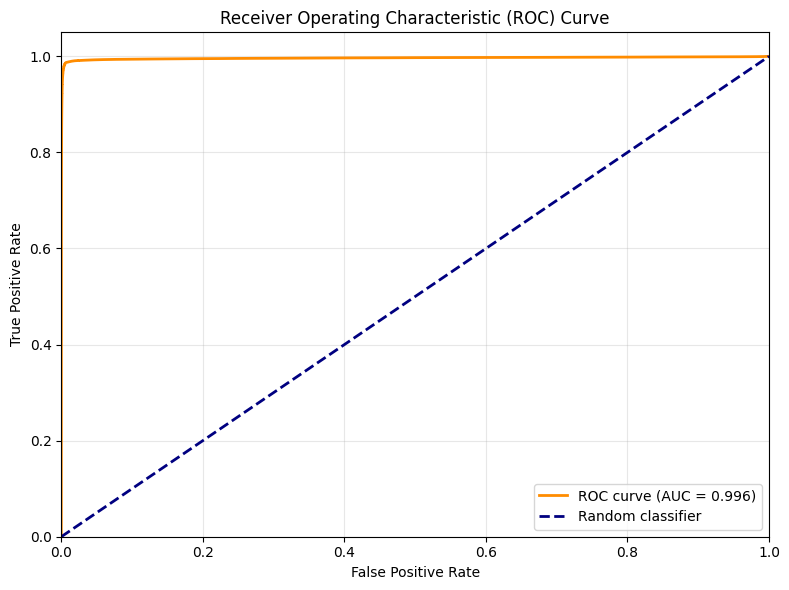

Построение графика Accuracy vs Threshold...


Computing accuracy curve: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


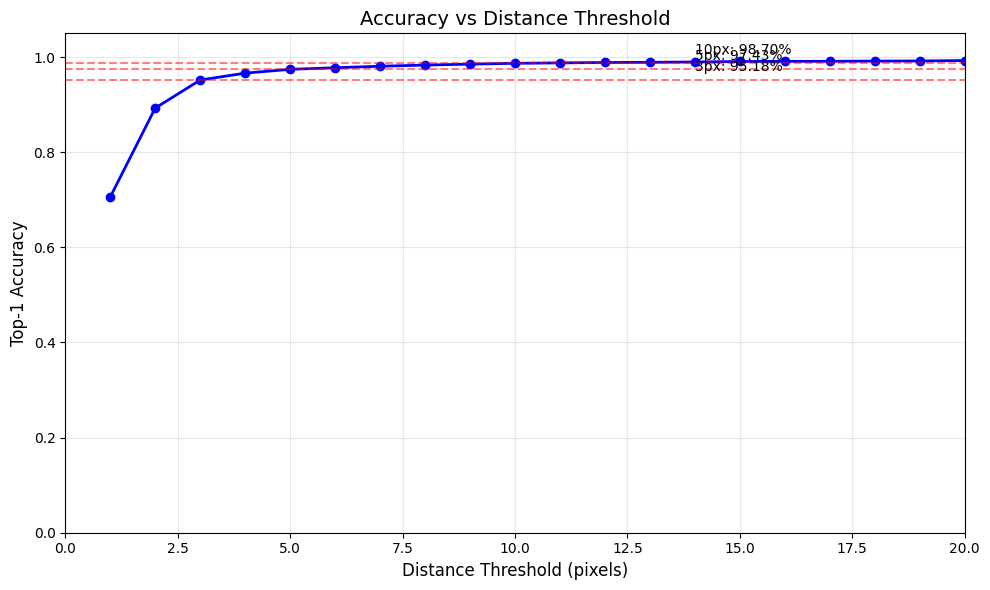

Построение графика ошибки по ключевым точкам...


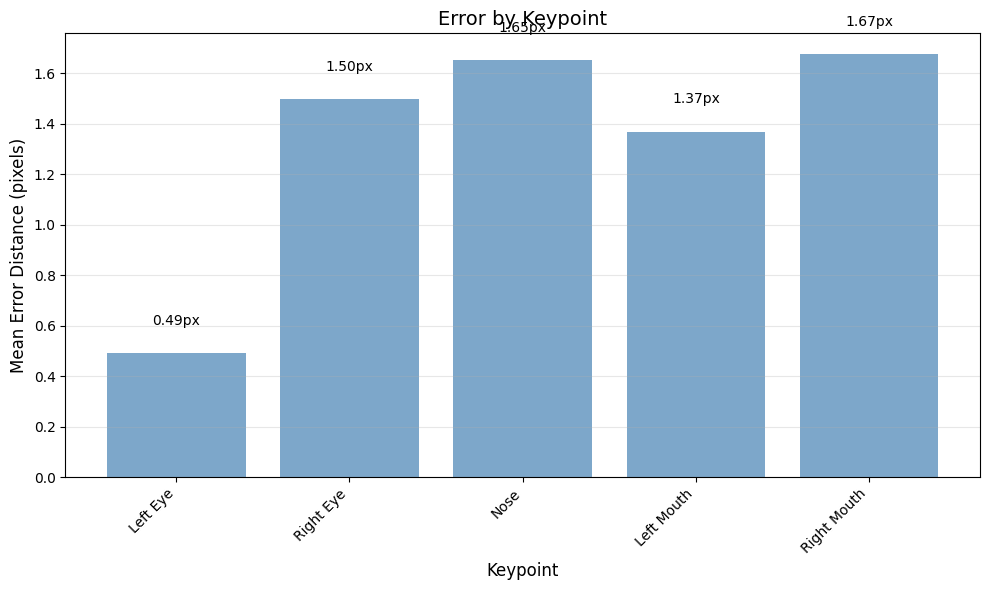

Визуализация heatmaps...


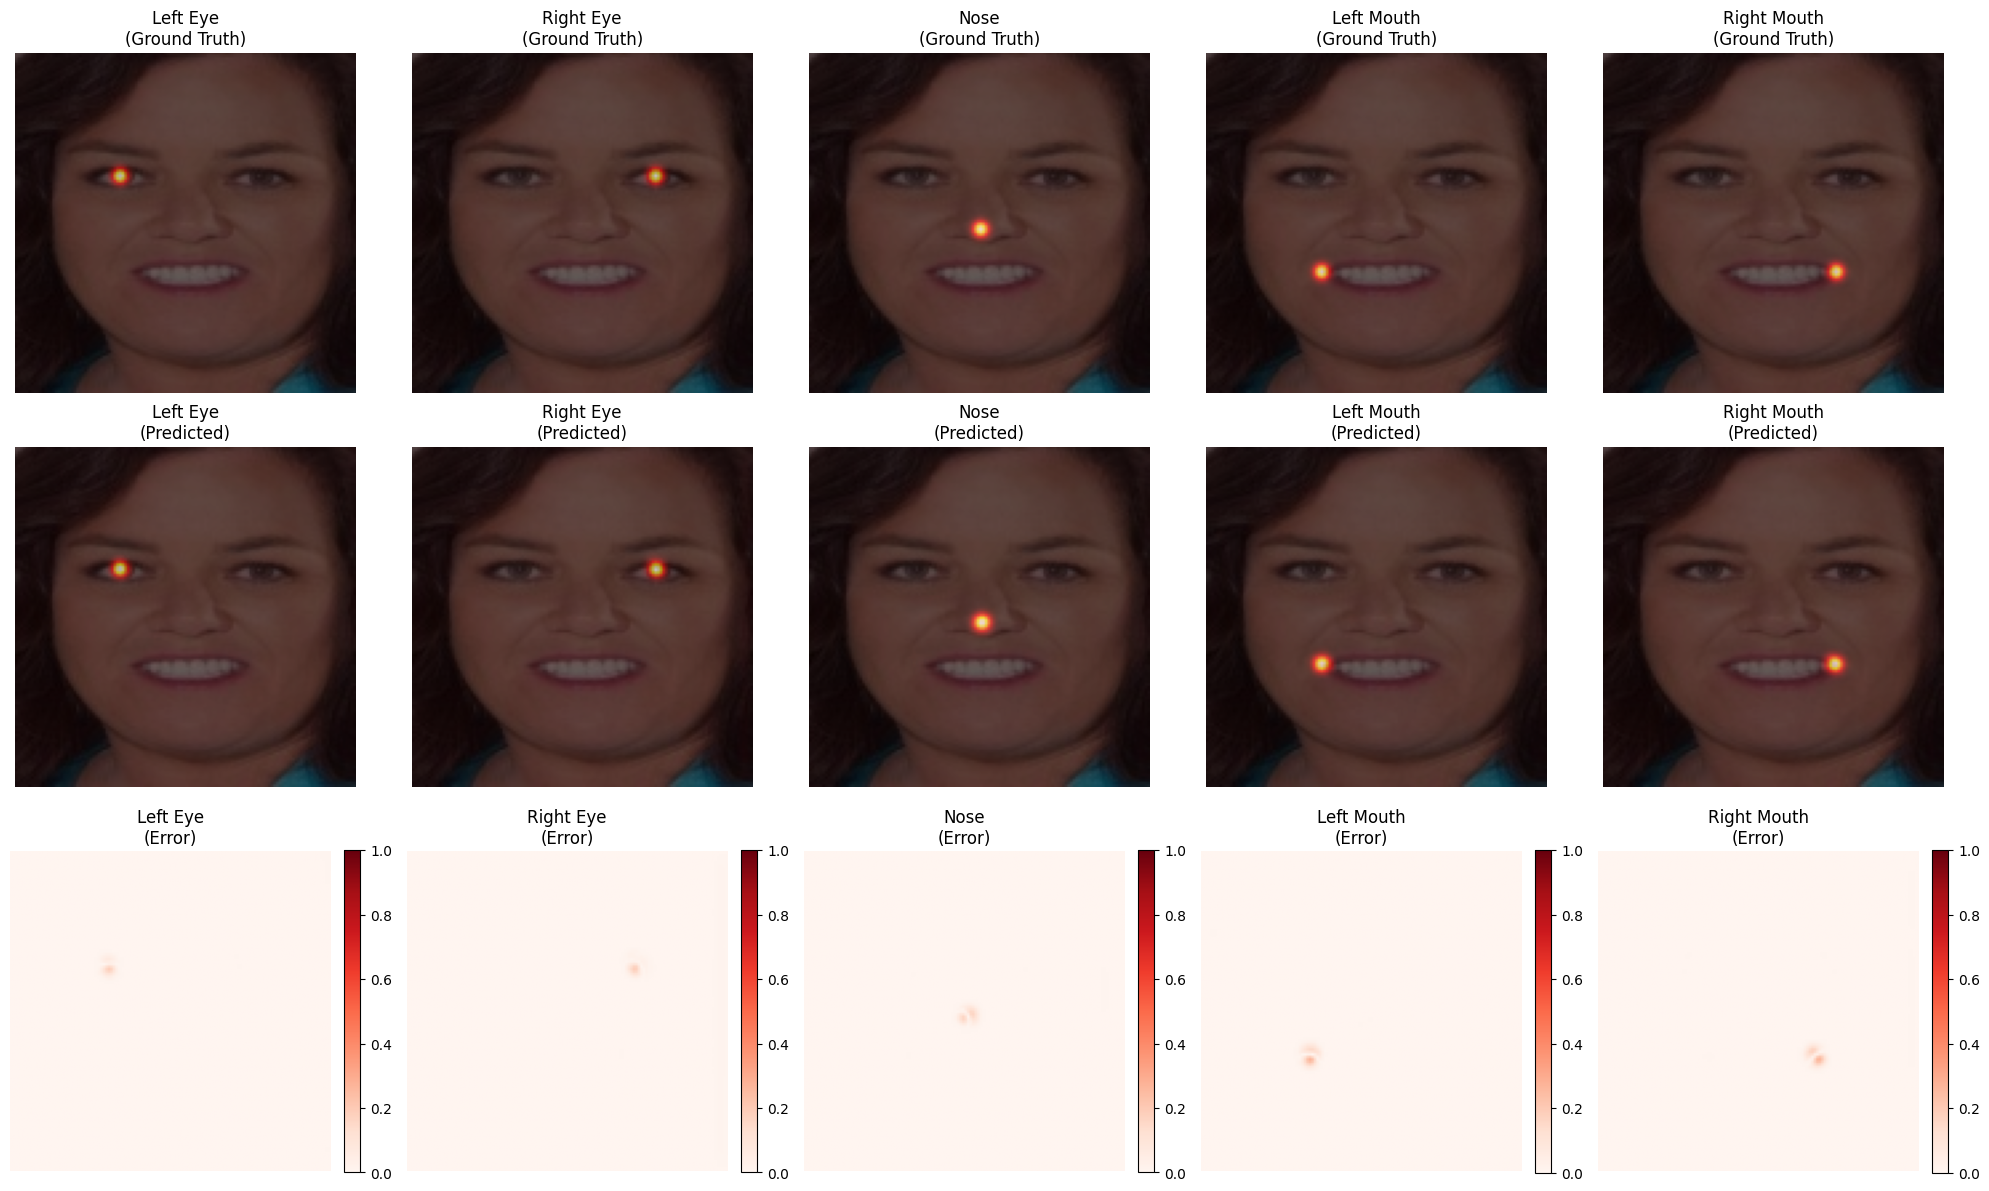

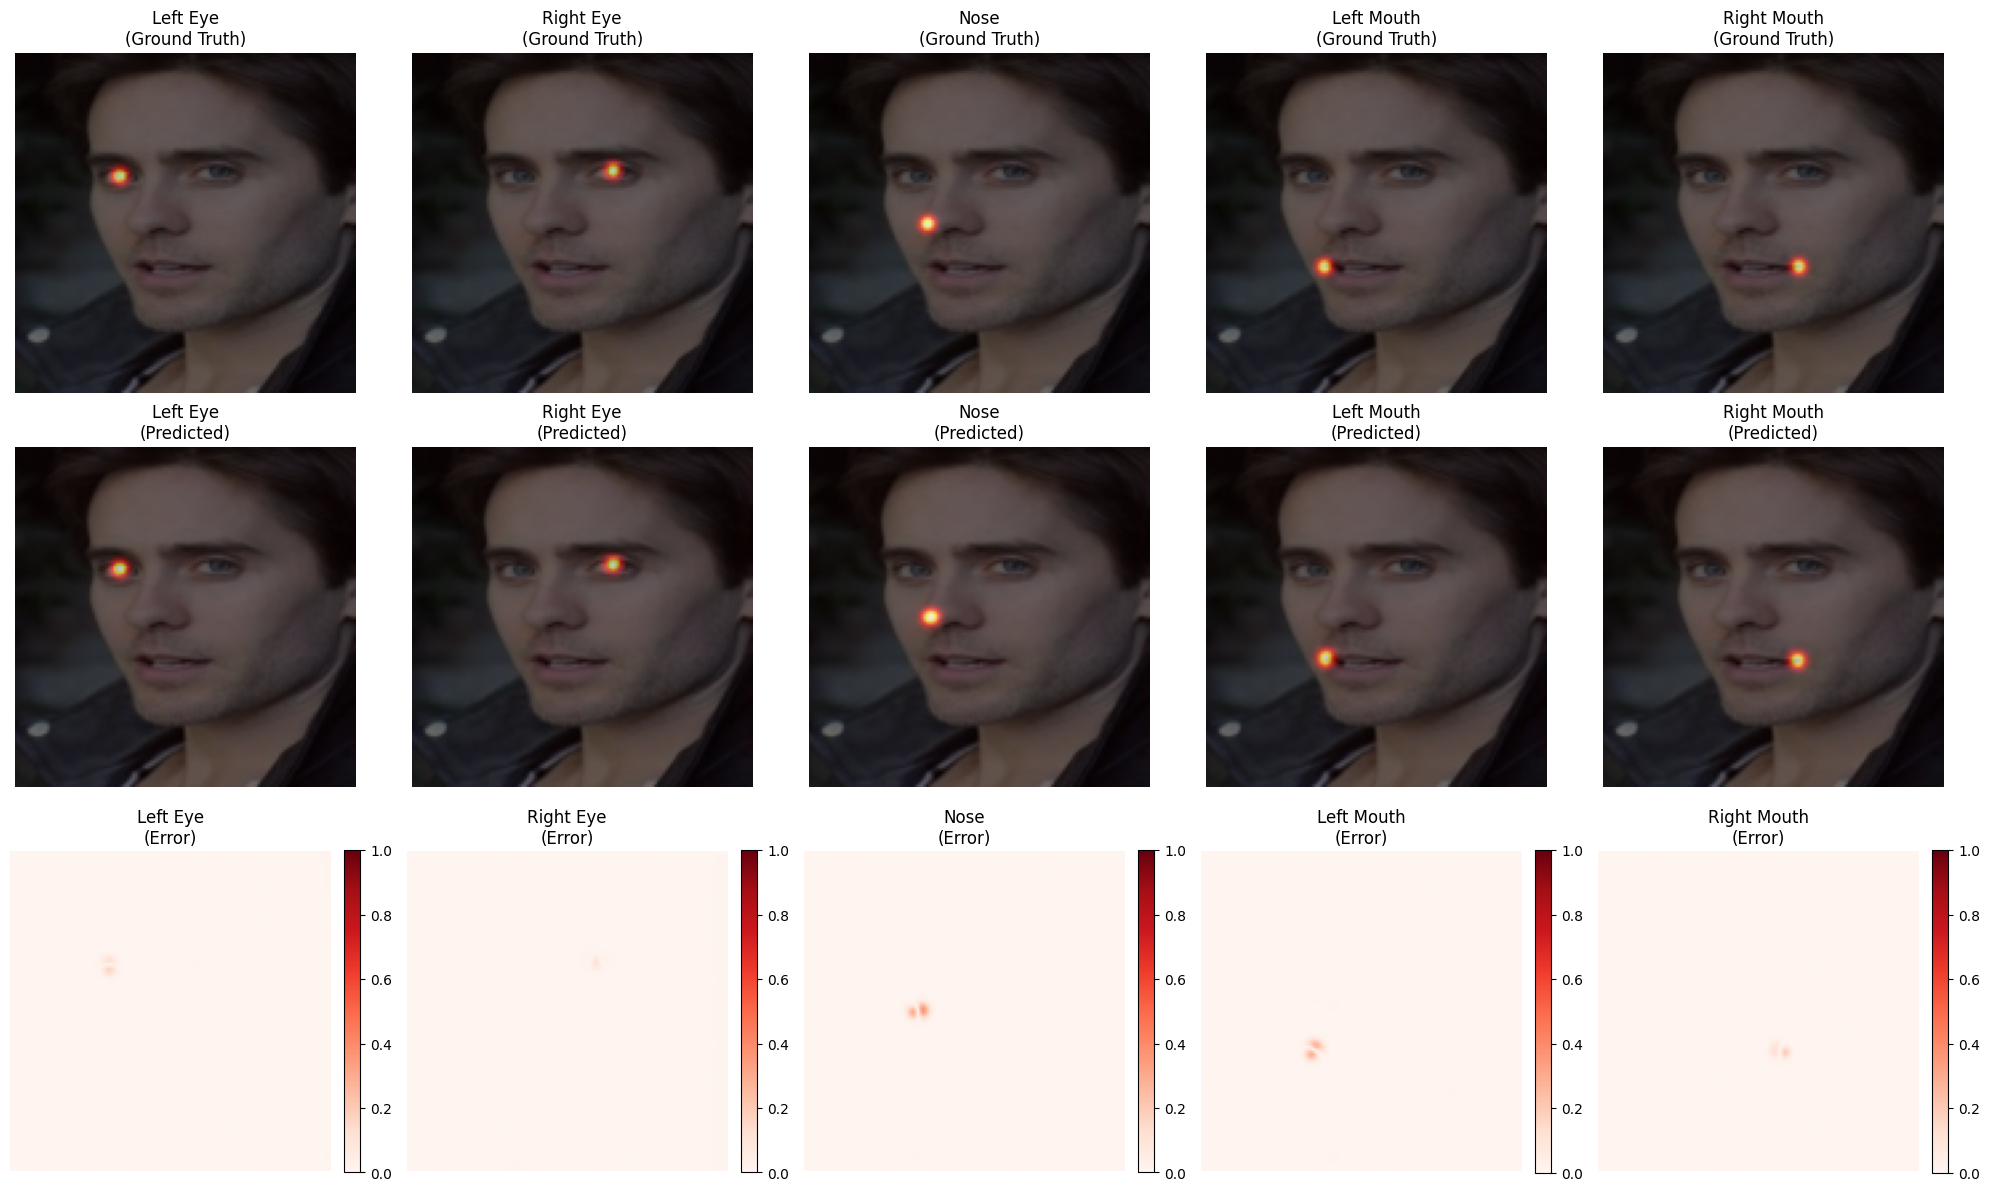

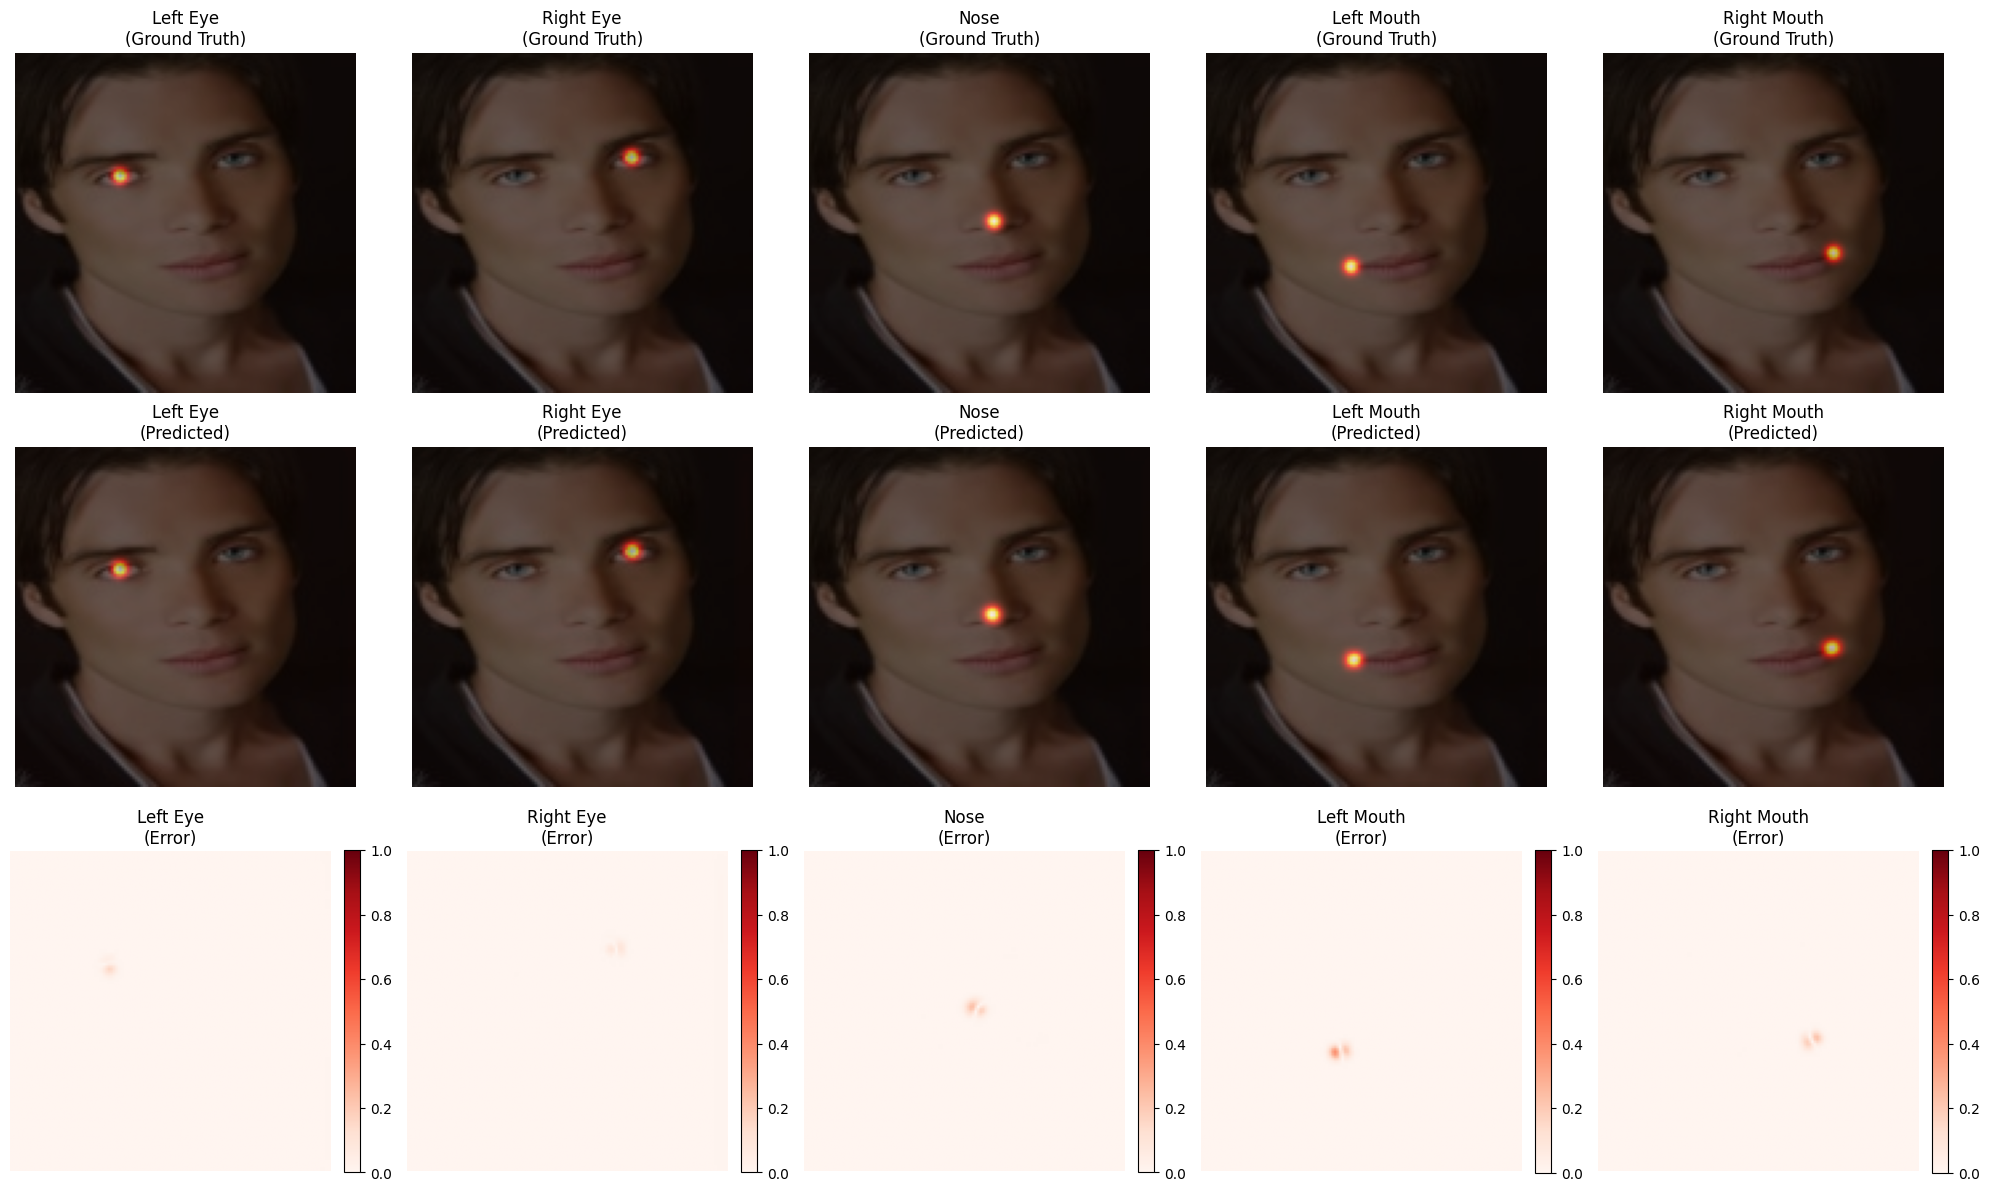

Визуализация ключевых точек...


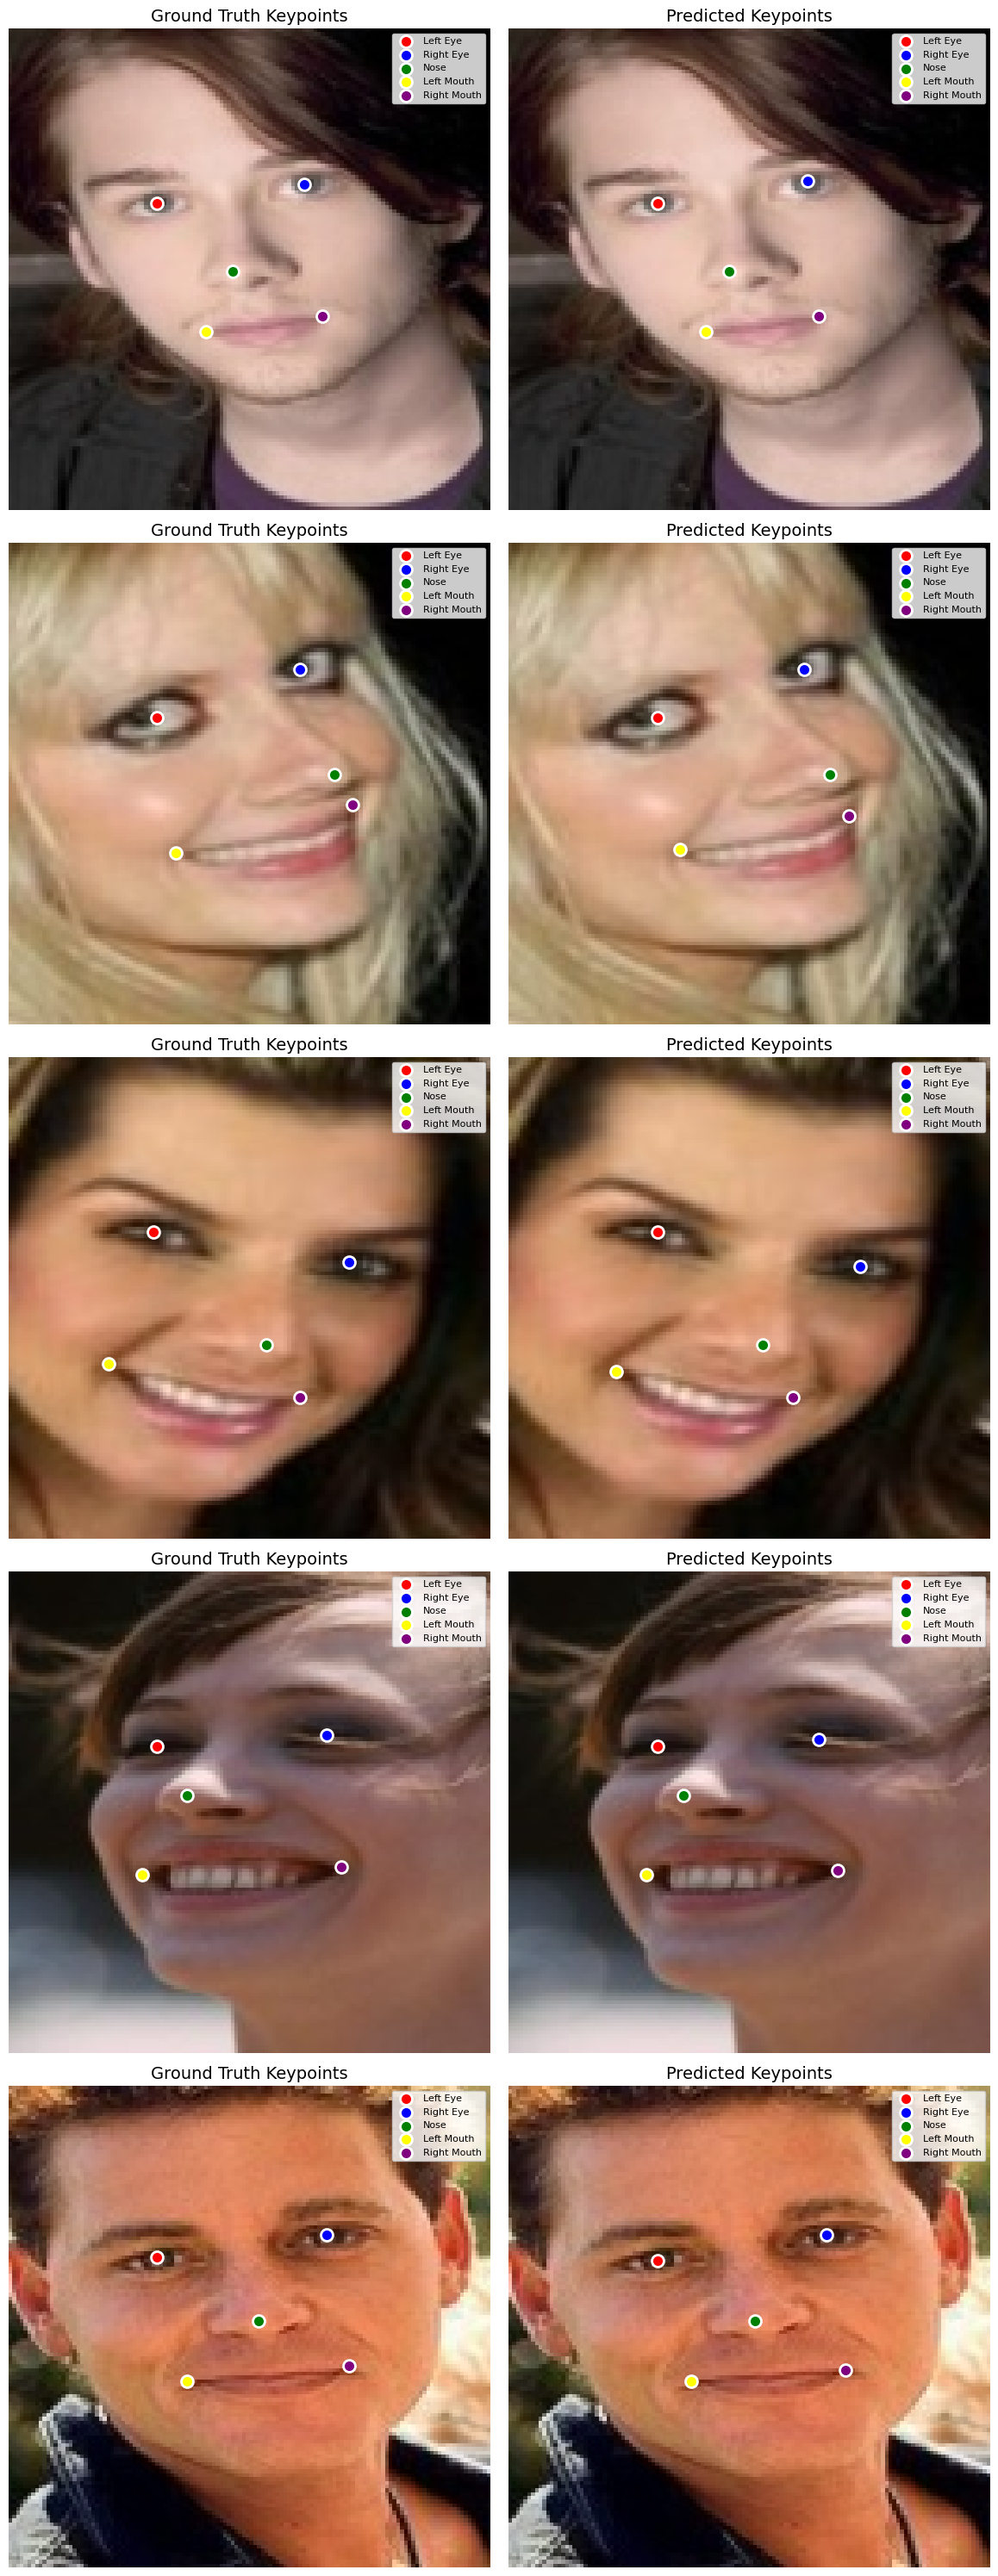

In [ ]:
# Функция для полного тестирования с визуализацией
def test_model(model, test_loader, checkpoint_path=None, device='cuda'):
    if checkpoint_path is not None:
        print(f"Загрузка модели из {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    evaluator = ModelEvaluator(model, test_loader, device)

    metrics, predictions, targets, images = evaluator.compute_metrics()

    evaluator.print_metrics(metrics)
    
    if metrics['roc_auc'] is not None:
        evaluator.plot_roc_curve(predictions, targets)

    print("Построение графика Accuracy vs Threshold...")
    evaluator.plot_accuracy_by_threshold(predictions, targets, max_threshold=20)

    print("Построение графика ошибки по ключевым точкам...")
    evaluator.plot_per_keypoint_error(metrics)

    print("Визуализация heatmaps...")
    evaluator.visualize_predictions(images, predictions, targets, num_samples=3)

    print("Визуализация ключевых точек...")
    evaluator.visualize_keypoints(images, predictions, targets, num_samples=5)
    
    return metrics, predictions, targets, images

metrics, predictions, targets, images = test_model(
    model=model,
    test_loader=test_loader,
    checkpoint_path='/kaggle/input/hourglass-10/pytorch/default/1/hourglass_model_10_epoch.pth',
    device='cuda'
)

# Выравнивание фотографий
Нужно провести выравнивание с помощью афинных координат
Также при вычислении афинных координат были использованы стандартные позиции для глаз в выровненном изображении (128x128):
```
left_eye = (38, 48)
right_eye = (90, 48)
```

In [ ]:
class FaceAligner:    
    def __init__(self, model, device='cuda', output_size=TARGET_SIZE):
        """
        Args:
            model: обученная модель для предсказания ключевых точек
            checkpoint_path: путь к весам модели
            device: устройство для вычислений
            output_size: размер выходного выровненного изображения
        """
        self.device = device
        self.model = model.to(device)
        self.output_size = output_size

        self.model.eval()
    
    def predict_keypoints(self, image):
        """
        Предсказывает ключевые точки на изображении
        
        Args:
            image: PIL Image или numpy array [H, W, 3]
        
        Returns:
            keypoints: list of (x, y) coordinates
        """
        if isinstance(image, np.ndarray):
            # Предполагаем что изображение уже 128x128
            img_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        else:
            # PIL Image
            img_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
        
        img_tensor = img_tensor.unsqueeze(0).to(self.device)

        with torch.no_grad():
            pred_heatmaps = self.model(img_tensor)
            heatmap = pred_heatmaps[-1][0]

        heatmap_np = heatmap.cpu().numpy()
        keypoints = []
        
        for k in range(heatmap_np.shape[0]):
            hm = heatmap_np[k]
            y, x = np.unravel_index(np.argmax(hm), hm.shape)
            keypoints.append((x, y))
        
        return keypoints
    
    def compute_affine_transform(self, keypoints):
        """
        Вычисляет афинное преобразование для выравнивания лица
        
        Args:
            keypoints: list of (x, y) - должны быть в порядке:
                      [left_eye, right_eye, nose, left_mouth, right_mouth]
        
        Returns:
            M: матрица афинного преобразования 2x3
        """
        left_eye = np.array(keypoints[0])
        right_eye = np.array(keypoints[1])
        
        eyes_center = (left_eye + right_eye) / 2.0

        dY = right_eye[1] - left_eye[1]
        dX = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dY, dX))
        
        # Желаемые позиции ключевых точек в выровненном изображении
        # Стандартные позиции для выровненного лица 128x128 - best practies ;)
        desired_left_eye = (38, 48)
        desired_right_eye = (90, 48)

        desired_dist = desired_right_eye[0] - desired_left_eye[0]
        actual_dist = np.linalg.norm(right_eye - left_eye)
        scale = desired_dist / actual_dist

        desired_eyes_center = ((desired_left_eye[0] + desired_right_eye[0]) / 2,
                               (desired_left_eye[1] + desired_right_eye[1]) / 2)
        
        # Получаем матрицу афинного преобразования
        M = cv2.getRotationMatrix2D(
            center=(float(eyes_center[0]), float(eyes_center[1])),
            angle=float(angle),
            scale=float(scale)
        )

        tX = desired_eyes_center[0] - eyes_center[0]
        tY = desired_eyes_center[1] - eyes_center[1]
        M[0, 2] += tX
        M[1, 2] += tY
        
        return M
    
    def align_face(self, image, keypoints):
        """
        Выравнивает лицо с помощью афинного преобразования
        
        Args:
            image: numpy array [H, W, 3] в формате RGB
            keypoints: list of (x, y) координат
        
        Returns:
            aligned: выровненное изображение [output_size[0], output_size[1], 3]
        """
        M = self.compute_affine_transform(keypoints)
        
        # Применяем преобразование
        aligned = cv2.warpAffine(
            image,
            M,
            self.output_size,
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_REPLICATE
        )
        
        return aligned
    
    def process_single_image(self, image_path):
        """
        Обрабатывает одно изображение: предсказывает точки и выравнивает
        
        Args:
            image_path: путь к изображению
        
        Returns:
            aligned_image: выровненное изображение
            keypoints: предсказанные ключевые точки
            success: True если успешно, False если ошибка
        """
        try:
            image = cv2.imread(str(image_path))
            if image is None:
                return None, None, False
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image_resized = cv2.resize(image_rgb, (128, 128))

            keypoints = self.predict_keypoints(image_resized)

            aligned = self.align_face(image_resized, keypoints)
            
            return aligned, keypoints, True
            
        except Exception as e:
            print(f"Ошибка при обработке {image_path}: {e}")

            return None, None, False
    
    def process_dataset(self, input_dir, output_dir):
        """
        Обрабатывает весь датасет: выравнивает все изображения
        
        Args:
            input_dir: директория с исходными изображениями
            output_dir: директория для сохранения выровненных изображений
        """
        input_path = Path(input_dir)
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

        image_files = []
        image_files.extend(list(input_path.glob(f'*{'.jpg'}')))

        successful = 0
        failed = 0

        for img_path in tqdm(image_files, desc='Выравнивание изображений'):
            aligned, keypoints, success = self.process_single_image(img_path)
            
            if success:
                original_filename = img_path.name
                output_filename = output_path / original_filename

                aligned_bgr = cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(output_filename), aligned_bgr)
                
                successful += 1
            else:
                failed += 1

        print(f"РЕЗУЛЬТАТЫ ОБРАБОТКИ")
        print(f"Всего изображений:       {len(image_files)}")
        print(f"Успешно обработано:      {successful}")
        print(f"Ошибок:                  {failed}")
        print(f"Успешность:              {successful/len(image_files)*100:.2f}%")
    
    def visualize_alignment(self, input_dir, output_dir, num_samples=5):
        """
        Визуализирует примеры выравнивания (до/после)
        
        Args:
            input_dir: директория с исходными изображениями
            output_dir: директория с выровненными изображениями
            num_samples: количество примеров для визуализации
        """
        
        input_path = Path(input_dir)
        output_path = Path(output_dir)
        
        input_images = list(input_path.glob('*.jpg'))[:num_samples]
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i, input_img_path in enumerate(input_images):
            original = cv2.imread(str(input_img_path))
            original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            original_resized = cv2.resize(original, (128, 128))

            output_img_path = output_path / input_img_path.name
            if output_img_path.exists():
                aligned = cv2.imread(str(output_img_path))
                aligned = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
            else:
                aligned = np.zeros_like(original_resized)

            keypoints_original = self.predict_keypoints(original_resized)

            keypoints_aligned = self.predict_keypoints(aligned)
            
            # Визуализируем исходное изображение
            axes[i, 0].imshow(original_resized)
            axes[i, 0].set_title(f'Original\n{input_img_path.name}', fontsize=10)
            axes[i, 0].axis('off')
            
            # Визуализируем исходное с ключевыми точками
            axes[i, 1].imshow(original_resized)
            colors = ['red', 'blue', 'green', 'yellow', 'purple']
            keypoint_names = ['L_Eye', 'R_Eye', 'Nose', 'L_Mouth', 'R_Mouth']
            for k, (x, y) in enumerate(keypoints_original):
                axes[i, 1].scatter(x, y, c=colors[k], s=100, marker='o',
                                  edgecolors='white', linewidths=2,
                                  label=keypoint_names[k])
            axes[i, 1].set_title('Original + Keypoints', fontsize=10)
            axes[i, 1].axis('off')
            if i == 0:
                axes[i, 1].legend(loc='upper right', fontsize=8)
            
            # Визуализируем выровненное с ключевыми точками
            axes[i, 2].imshow(aligned)
            for k, (x, y) in enumerate(keypoints_aligned):
                axes[i, 2].scatter(x, y, c=colors[k], s=100, marker='o',
                                  edgecolors='white', linewidths=2)
            axes[i, 2].set_title('Aligned + Keypoints', fontsize=10)
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

Выравнивание изображений: 100%|██████████| 10013/10013 [03:29<00:00, 47.82it/s]


РЕЗУЛЬТАТЫ ОБРАБОТКИ
Всего изображений:       10013
Успешно обработано:      10013
Ошибок:                  0
Успешность:              100.00%

Визуализация примеров выравнивания...


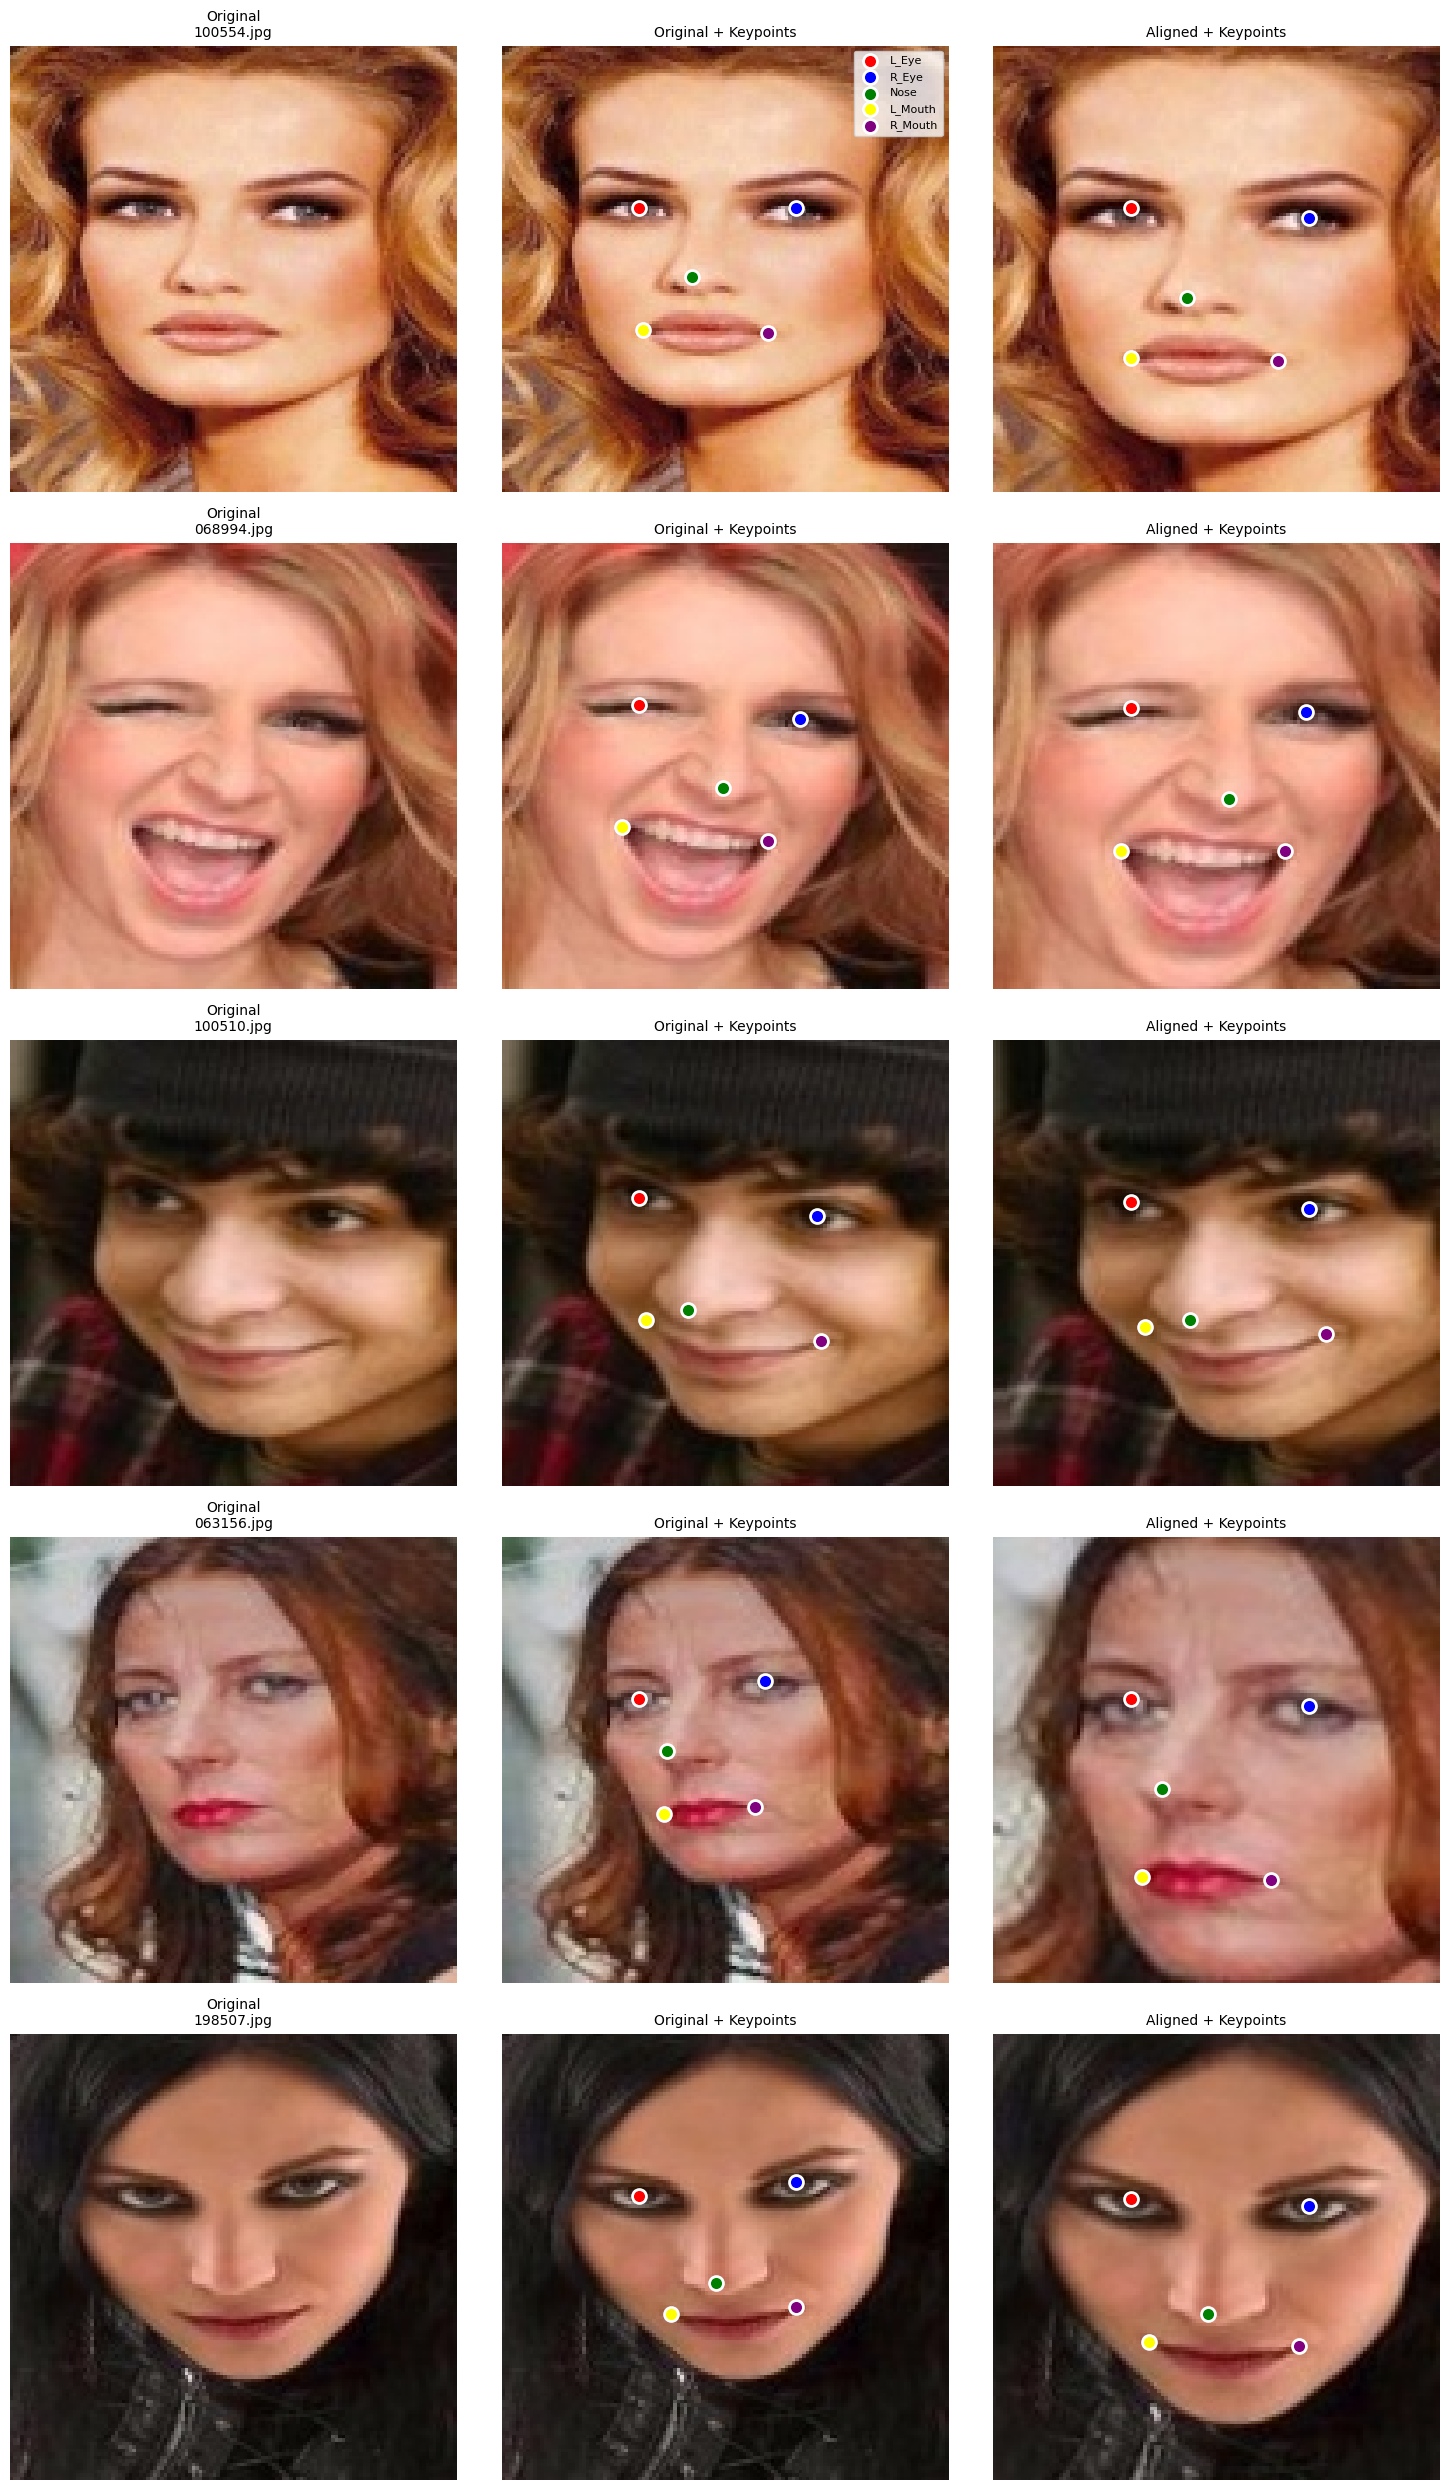

In [ ]:
# Упрощенная функция для быстрого использования
def align_all_faces(model, input_dir, output_dir, 
                   device='cuda', visualize=True):
    """
    Простая функция для выравнивания всех лиц в датасете
    
    Args:
        model: модель для предсказания ключевых точек
        checkpoint_path: путь к весам модели
        input_dir: директория с исходными изображениями
        output_dir: директория для сохранения выровненных изображений
        device: устройство
        visualize: показать ли примеры выравнивания
    """
    aligner = FaceAligner(
        model=model,
        device=device,
        output_size=TARGET_SIZE
    )

    aligner.process_dataset(
        input_dir=input_dir,
        output_dir=output_dir,
    )

    if visualize:
        print("\nВизуализация примеров выравнивания...")
        aligner.visualize_alignment(
            input_dir=input_dir,
            output_dir=output_dir,
            num_samples=5
        )

align_all_faces(
    model=model,
    input_dir=PROCESSED_IMAGES_PATH,
    output_dir=ALIGNED_IMAGES_PATH,
    device='cuda',
    visualize=True
)

# Сохраним все выровненные изображения как архив

In [ ]:
def archive_aligned_images(
    source_folder,
    output_zip_path
):
    source_folder = Path(source_folder)

    if not source_folder.exists():
        raise FileNotFoundError(f"Папка не найдена: {source_folder}")
    
    if not source_folder.is_dir():
        raise ValueError(f"Путь не является папкой: {source_folder}")

    if output_zip_path is None:
        output_zip_path = source_folder.parent / f"{source_folder.name}.zip"
    else:
        output_zip_path = Path(output_zip_path)

    output_zip_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Получение списка всех файлов
    all_files = list(source_folder.rglob('*'))
    file_list = [f for f in all_files if f.is_file()]
  
    # Создание архива
    with zipfile.ZipFile(
        output_zip_path, 
        'w', 
        compression=zipfile.ZIP_DEFLATED,
        compresslevel=6
    ) as zipf:
        
        for file_path in tqdm(file_list, desc="Архивация"):
            arcname = file_path.relative_to(source_folder)
            zipf.write(file_path, arcname=arcname)
    
    # Информация о результате
    archive_size = output_zip_path.stat().st_size
    
    print(f"\n Архивация завершена!")
    print(f" Размер архива: {archive_size / (1024**2):.2f} MB")
    
    return str(output_zip_path)

archive_path = archive_aligned_images(
    source_folder=ALIGNED_IMAGES_PATH,
    output_zip_path=ALIGNED_IMAGES_ZIP,
)

Архивация: 100%|██████████| 10013/10013 [00:03<00:00, 3203.27it/s]



 Архивация завершена!
 Размер архива: 65.61 MB
